# 1. Einleitung
Diese Studienarbeit beschäftigt sich mit der explorativen Datenanalyse sowie der Zeitreihenanalyse von Verkaufsdaten der letzten 2 Jahre von Rossmann in verschiedenen Filialen. Das Ziel dieser Arbeit ist auf Basis der gewonnenen Erkenntnisse eine Vorhersage der Verkaufsentwicklung für die nächsten 6 Wochen zu erstellen. Die Motivation für die Durchführung dieser Analyse liegt darin, die Verkäufe von Rossmann besser zu verstehen und somit mögliche Optimierungspotenziale aufzudecken. Dabei sollen auch Unterschiede in der Verkaufsentwicklung zwischen verschiedenen Filialtypen identifiziert werden, um zielgerichtete Handlungsempfehlungen ableiten zu können.

Die Analyse der Verkaufsdaten von Rossmann ermöglicht es, auf Basis von umfassenden Daten einen Einblick in das Kaufverhalten der Kunden und die Leistung der Filialen zu erhalten. Dabei sollen Trends und Muster in der Verkaufsentwicklung, wie beispielsweise saisonale Schwankungen, Einflüsse von Promo-Aktionen oder auch Unterschiede in der Verkaufsentwicklung zwischen verschiedenen Filialtypen, identifiziert werden. Auf dieser Grundlage werden zukünftige Verkaufstrends prognostiziert.  

Die Erkenntnisse aus der vorliegenden Studienarbeit können somit nicht nur für Rossmann, sondern auch für andere Einzelhändler und Unternehmen mit ähnlicher Ausrichtung von großem Nutzen sein. Zudem können die Ergebnisse dieser Analyse als Grundlage für weitere Forschung und Entwicklung im Bereich des Einzelhandels dienen.

# 2. Problemstellung
Rossmann ist ein führender Drogeriemarkt in Deutschland und betreibt mehr als 4500 Filialen in Europa, davon mehr als 2200 Filialen in Deutschland.<sup>[1]</sup> Das Geschäftsmodell basiert auf einem breiten Sortiment an Produkten zu niedrigen Preisen und einem hohen Fokus auf Kundenzufriedenheit. Der Verkauf erfolgt in Filialen sowie über den Online-Shop. Zusätzlich bietet Rossmann zahlreiche Eigenmarken und führt regelmäßig Aktionen durch, um Kunden zu binden und neue Kunden zu gewinnen.  

Das Verständnis des Geschäftsmodells von Rossmann ist entscheidend für die Durchführung der explorativen Datenanalyse und der Zeitreihenanalyse. Denn nur durch das Verständnis der Geschäftspraktiken und der Verkaufsstrategie kann sichergestellt werden, dass die Analysen auf aussagekräftige Ergebnisse zurückgreifen und so praxisrelevante Handlungsempfehlungen für Rossmann abgeleitet werden können.

<sup>[1]</sup> https://unternehmen.rossmann.de/ueber-das-unternehmen.html#:~:text=Mit%2060.500%20Mitarbeitern%20in%20Europa,den%20gr%C3%B6%C3%9Ften%20Drogeriemarktketten%20in%20Europa, abgerufen am 05.05.2023.

# 3. Datensatz
Der verwendete Datensatz stammt aus der Kaggle Competition "Rossman Store Sales".<sup>[2]</sup>  
Dieser besteht aus den folgenden 4 Dateien:
- train.csv
- test.csv
- store.csv
- sample-submission.csv

Die Datei "sample-submission.csv" enthält lediglich das vorgegebene Format für die Kaggle Competion und wird dementsprechend im Rahmen dieser Arbeit nicht betrachtet.

<sup>[2]</sup> https://www.kaggle.com/competitions/rossmann-store-sales

## Package-Installation & Imports
Im ersten Schritt sollte eine Python-Umgebung erstellt werden, welche alle benötigten Python-Packages installiert hat. Hierzu sind alle verwendeten Packages in der Datei "requirements.txt" aufgelistet. Diese kann verwendet werden um beispielsweise mit anaconda über den Befehl ```conda create --name dbuas-data-mining-studienarbeit-dariusmix --file requirements.txt```  
eine neue Python-Umgebung aufzusetzen. Im Anschluss muss die neu erstellte Umgebung über den Befehl ```conda activate dbuas-data-mining-studienarbeit-dariusmix``` aktiviert werden. Die verwendeten Befehle sind zusätzlich noch einmal in der README.md unter "Setup" aufgelistet.  

Nachdem alle benötigten Packages installiert wurden, können diese mit dem folgenden Code-Block importiert werden.

In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import sqlite3

from ydata_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose as sm
from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

Importing plotly failed. Interactive plots will not work.


## Einlesen der Daten in ein pandas Dataframe  
Nachdem die benötigten Packages importiert wurden, werden die CSV-Dateien "train.csv", "store.csv" sowie "test.csv" eingelesen und in Pandas DataFrames gespeichert. Hierzu werden die Dateipfade der Dateien als Strings in den Variablen "FILEPATH_TRAIN", "FILEPATH_STORE" und "FILEPATH_TEST" gespeichert und anschließend mithilfe von der Pandas Funktion read_csv() eingelesen und in DataFrames umgewandelt. ```low_memory=False``` wird verwendet, um sicherzustellen, dass Pandas genügend Speicherplatz für die Verarbeitung der Daten reserviert.

Im Anschluss werden die eingelesenen Daten über die Store ID zu einem DataFrame zusammengeführt.

Der Unterschied zwischen dem Train-Datensatz und dem Test-Datensatz besteht darin, dass der Test-Datensatz keine Informationen über die Umsätze und Kundenanzahl enthält. Das liegt daran, dass der Test-Datensatz die Zukunft abbilden soll und der Train-Datensatz die Vergangenheit. Dementsprechend sollen für die Datumsangaben aus dem Test-Datensatz die Verkaufsdaten vorhergesagt werden.

In [2]:
FILEPATH_TRAIN = os.path.join("input", "train.csv")
FILEPATH_STORE = os.path.join("input", "store.csv")
FILEPATH_TEST = os.path.join("input", "test.csv")

IMG_PATH = os.path.join("output", "images")

if not os.path.exists(IMG_PATH):
    os.makedirs(IMG_PATH)

In [3]:
df_train = pd.read_csv(FILEPATH_TRAIN, low_memory=False)
df_store = pd.read_csv(FILEPATH_STORE)
df_test = pd.read_csv(FILEPATH_TEST, low_memory=False)

In [4]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
df_train_store = pd.merge(df_train, df_store, on="Store", how="inner")
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


## Explorative Datenanalyse (EDA)
Im ersten Schritt der EDA wird mithilfe des Python-Packages "ydata_profiling" der Profiling Report für die eingelesenen Daten erstellt. Dieser befindet sich als html-Datei im output Ordner unter dem Dateinamen "rossmann-store-sales-train-store.html".

### Profiling Report

Die Daten enthalten die täglichen Verkaufszahlen (Sales) sowie die Anzahl der Kunden (Customers) von 1115 Filialen aus dem Zeitraum vom 01. Januar 2013 bis zum 31. Juli 2015. Weiterhin beinhalten die Daten Informationen darüber, ob die Filiale an dem jeweiligen Tag geöffnet war (Open), ob eine Aktion (Promo) stattgefunden hat und ob es sich um einen gesetzlichen Feiertag (StateHoliday) oder Schulferien (SchoolHoliday) handelte. Außerdem sind weitere Informationen zu den Filialen wie der Filialtyp (StoreType), das Sortiment (Assortment), die Entfernung zum nächsten Wettbewerber (CompetitionDistance) sowie Angaben zu weiteren Promo-Aktionen (Promo2) Bestandteil der Daten.

- Die Daten enthalten 1.017.209 Einträge und 18 Variablen.
- Es gibt insgesamt 2.173.431 fehlende Zellen. Diese fehlen lediglich in den Filialdaten und müssen dementsprechend für die EDA nicht betrachtet werden.  
Für die Zeitreihenanalyse / Vorhersage müssen diese fehlenden Zellen durch sinnvolle Einträge ersetzt werden oder aus den Daten entfernt werden.
- Die Daten enthalten keine doppelten Zeilen, dementsprechend müssen keine Redundanzen entfernt werden. 

Variablen  
- Die Variable "Date" gibt den Zeitraum der Daten an, der erste Eintrag ist der 01.01.2013 und der letzte Eintrag ist der 17.09.2015.
- Die Variable "Store" ist die eindeutige ID für jeden der 1115 unterschiedlichen Filialen. Über diese eindeutige ID wurde die Datei "train.csv" mit der zweiten Datei "store.csv" zusammengeführt.
- Die Variable "Sales" gibt den Umsatz für den jeweiligen Tag an, wobei es 172.871 Einträge (ca. 17% aller Einträge) gibt, an denen kein Umsatz generiert wurde (Sales = 0). Der Mittelwert der Sales liegt bei 5744, beinhaltet aber auch die Tage, an denen die Sales 0 sind und die Stores geschlossen sind. Wenn diese Tage herausgefiltert werden, sollte der Mittelwert aussagekräftiger sein. 
- Die Variable "Customers" gibt die Anzahl der Kunden für den jeweiligen Tag an.  
Es sollte eine weitere Variable berechnet werden, die den Umsatz pro Kunden angibt (Sales / Customers).
- Die Variable "Open" gibt an, ob das Geschäft an dem jeweiligen Tag geöffnet war. Es gibt 172817 Einträge, bei denen die Stores geschlossen waren (Open = 0). 
- Die Variable "Promo" gibt an, ob ein Geschäft an dem jeweiligen Tag eine Werbeaktion durchgeführt hat. 
- Die Variable "StateHoliday" gibt an, ob es an dem Tag einen gesetzlichen Feiertag gab. Normalerweise sind alle Geschäfte, mit wenigen Ausnahmen, an gesetzlichen Feiertagen geschlossen.
- Die Variable "SchoolHoliday" gibt an, ob das Geschäft von der Schließung öffentlicher Schulen betroffen war.  
- Die Variable "StoreType" unterscheidet die Filialen zwischen 4 verschiedenen Typen (a, b, c, d).
- Die Variable "Assortment" gibt an, welches Sortiment die Filiale im Angebot hat (a = Basis, b = extra, c = erweitert).
- Die Variable "CompetitionDistance" gibt die Entfernung in Metern bis zum nächstgelegenen Konkurrenzgeschäft an. Die Durchschnittliche Entfernung beträgt 5430 Meter. Diese Variable enthält 2642 fehlende Werte.
- Die Variablen "CompetitionOpenSince[Month/Year]" geben an, seit wann das nächstgelegene Konkurrenzgeschäft existiert. Ein Großteil der fehlende Werte betrifft diese Spalten. 31,8% der Einträge enthält keine Information über diese Angabe. Insgesamt 646.696 der 2.173.431 fehlende Zellen fallen auf diese 2 Variablen.
- Die Variable "Promo2" gibt an, ob die Filiale an einer einer wiederkehrenden Promo-Aktion teilnimmt oder nicht.
- Die Variablen "Promo2Since[Week/Year]" geben an, seit wann die Filiale an der wiederkehrenden Promo2 teilnimmt.
- Die Variable "PromoInterval" gibt an, in welchen Monaten die Promo2 stattfindet. Es gibt 3 Optionen: "Jan,Apr,Jul,Oct", "Feb,May,Aug,Nov" und "Mar,Jun,Sept,Dec"  
Wenn die jeweilige Filiale an keiner Promo2 teilnimmt, enthalten die 3 Variablen NULL-Werte. Dies sind insgesamt 508.031 fehlende Zeilen (1.524.093 fehlende Zellen).

Korrelation  
Es ist zu erkennen, dass eine starke Korrelation zwischen der Anzahl der Kunden und dem Umsatz und eine mittelstarke Korrelation zwischen dem Umsatz und Promo. Zusätzlich besteht eine schwache negative Korrelation zwischen dem Umsatz und den Kunden mit dem Wochentag.
Die anderen Korrelationen (z.B. die Korrelationen mit der Variable Open sowie WeekOfYear + Month oder Promo2 + Promo2SinceYear) werden nicht näher betrachtet.

In [7]:
profile = ProfileReport(df_train_store, title="Pandas Profiling Report", explorative=True)
profile.to_file(os.path.join("output", "rossmann-store-sales-train-store.html"))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Hinzufügen neuer Variablen  
Im nächsten Schritt wird das Datum als Index des DataFrames gesetzt und zusätzliche zeitliche Variablen (Jahr, Monat, Tag und Kalenderwoche) sowie Umsatz pro Kunde hinzugefügt. Diese Variablen werden in den nachfolgenden Codeabschnitten für eine bessere Auswertung und Darstellung benötigt.

In [8]:
# Ersetzen des index durch die Spalte 'Date'
df_train_store.set_index('Date', inplace=True)

# Umwandeln des Datums in den Datentyp 'DatetimeIndex' 
df_train_store.index = pd.DatetimeIndex(df_train_store.index)

# Hinzufügen zeitlicher Variablen (Jahr, Monat, Tag und Kalenderwoche und das Datum als Spalte)
df_train_store['Year'] = df_train_store.index.year
df_train_store['Month'] = df_train_store.index.month
df_train_store['Day'] = df_train_store.index.day
df_train_store['WeekOfYear'] = df_train_store.index.isocalendar().week
df_train_store['Date'] = pd.to_datetime(df_train_store[['Year', 'Month', 'Day']])

# Berechnen einer neuen Variablen 'SalesPerCustomer' - gibt an, wie viel Umsatz je Kunde an dem jeweiligen Tag erwirtschaftet wurde
df_train_store['SalesPerCustomer'] = df_train_store['Sales']/df_train_store['Customers']

### Untersuchung der Variable "Open"
In diesem Abschnitt wird die Variable "Open" untersucht.  
Es gibt 172.871 Einträge, an welchem kein Umsatz erwirtschaftet wurde (Sales = 0). Bei 172.817 Einträgen davon war die jeweilige Filie geschlossen. Das bedeutet, dass es 54 Einträge gibt, an welchen die Filiale geöffnet war, aber keinen Umsatz erwirtschaftet hat. Dies könnte auf besondere externe Einflüsse hindeuten und wird im Rahmen dieser Arbeit nicht weiter betrachtet.

In der Grafik "Open + Wochentag" wird dargestellt, wie oft die Filialen an den 7 Wochentagen geöffnet bzw. geschlossen waren. Es ist zu erkennen, dass die Filialen standardmäßig von Montag bis Samstag geöffnet und am Sonntag geschlossen sind, es gibt jedoch an allen 7 Wochentagen Ausnahmen. 

In [9]:
df_train_store.Open.value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [10]:
# Anzeige der Anzahl der Einträge, an welchen die Läden geschlossen (Open = 0) waren und an welchen kein Umsatz (Sales = 0) generiert wurde
print('Anzahl Einträge Sales 0:              ', df_train_store[(df_train_store.Sales == 0)].shape[0])

# Anzeige der Anzahl der Einträge, an denen die Stores geschlossen (Open = 0) waren und kein Umsatz (Sales = 0) generiert wurde
print('Anzahl Store geschlossen & Sales = 0: ', df_train_store[(df_train_store.Open == 0) & (df_train_store.Sales == 0)].shape[0])

# Anzeige der Anzahl der Einträge, an denen die Stores geöffnet waren (Open = 1) und kein Umsatz (Sales = 0) generiert wurde
print('Anzahl Store geöffnet & Sales = 0:    ', df_train_store[(df_train_store.Open == 1) & (df_train_store.Sales == 0)].shape[0])

# Prüfen, ob es Einträge gibt, an denen der Store geschlossen war, aber Umsatz erwirtschaft wurde (dies sollte nicht vorkommen und könnte auf Fehlerhafte Daten hinweisen)
print('Anzahl Store geschlossen & Sales > 0: ', df_train_store[(df_train_store.Open == 0) & (df_train_store.Sales > 0)].shape[0])

Anzahl Einträge Sales 0:               172871
Anzahl Store geschlossen & Sales = 0:  172817
Anzahl Store geöffnet & Sales = 0:     54
Anzahl Store geschlossen & Sales > 0:  0


#### Grafik: Open + Wochentag

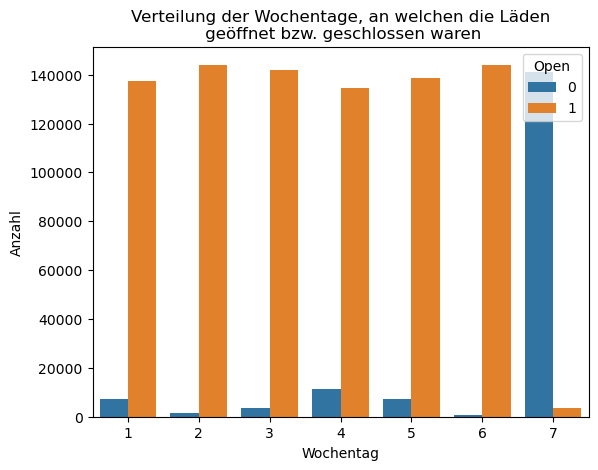

In [11]:
sns.countplot(x = 'DayOfWeek', hue = 'Open', data = df_train_store)
plt.title('Verteilung der Wochentage, an welchen die Läden\n geöffnet bzw. geschlossen waren')
plt.xlabel('Wochentag')
plt.ylabel('Anzahl')
plt.savefig(os.path.join(IMG_PATH, 'weekdays_open.png'))

### StoreTypes
In diesem Abschnitt werden die unterschiedlichen Filialtypen (Storetypes) untersucht.  
Es gibt vier verschiedene Typen, welche in den Daten als a, b, c und d vorliegen. Genauere Informationen über die unterschiede zwischen den vier Typen liegen nicht vor.

Im ersten Codeabschnitt werden alle 172.817 Einträge entfernt, bei welchen die jeweilige Filiale keinen Umsatz generiert hat, weil sie an diesem Tag geschlossen war. Dadurch werden nachfolgende Untersuchungen wie beispielsweise die Mittelwerte aussagekräftiger. Im Anschluss werden die Daten noch nach dem "StoreType" sortiert, um zu gewährleisten, dass die erstellten Grafiken die vier Typen in der alphabetischen Reihenfolge anzeigen.

In [12]:
df_train_store = df_train_store[(df_train_store["Open"] != 0) & (df_train_store['Sales'] != 0)]
df_train_store = df_train_store.sort_values(by='StoreType')

##### Sales je Storetype
Der Filialtyp B besitzt pro Filiale den höchsten Umsatz-Durchschnitt pro Tag, allerdings auch die wenigstens Einträge.

In [13]:
df_train_store.groupby('StoreType')[['StoreType', 'Sales']].describe()

Sales                                                      \
              count          mean          std     min      25%     50%   
StoreType                                                                 
a          457042.0   6925.697986  3277.351589    46.0  4695.25  6285.0   
b           15560.0  10233.380141  5155.729868  1252.0  6345.75  9130.0   
c          112968.0   6933.126425  2896.958579   133.0  4916.00  6408.0   
d          258768.0   6822.300064  2556.401455   538.0  5050.00  6395.0   

                              
                75%      max  
StoreType                     
a           8406.00  41551.0  
b          13184.25  38722.0  
c           8349.25  31448.0  
d           8123.25  38037.0

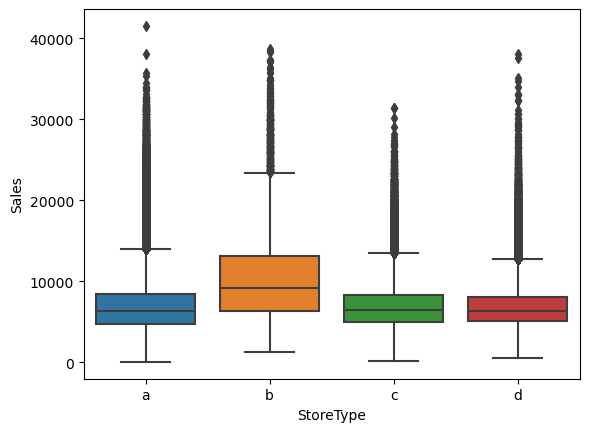

In [14]:
sns.boxplot(data=df_train_store, x='StoreType', y='Sales')
plt.savefig(os.path.join(IMG_PATH, 'storetypes_sales-je-storetype.png'))

##### Sales & Kunden je Storetype
Wenn wir uns nun die Anzahl der Kunden und die gesamten Umsatzzahlen pro Storetype angucken, sieht man, dass Storetype A die meisten Kunden und insgesamt auch den größten Umsatz erwirtschaftet.


In [15]:
df_train_store.groupby('StoreType')[['Customers', 'Sales']].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


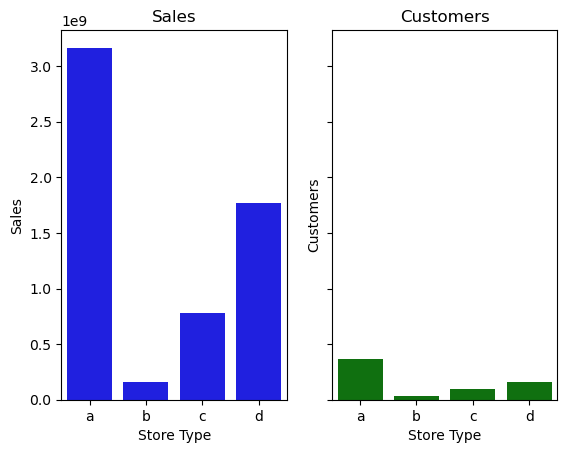

In [16]:
df_sales = df_train_store.groupby('StoreType')['Sales'].sum().reset_index()
df_customers = df_train_store.groupby('StoreType')['Customers'].sum().reset_index()

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

sns.barplot(data=df_sales, x='StoreType', y='Sales', color='b', ax=ax1)
sns.barplot(data=df_customers, x='StoreType', y='Customers', color='g', ax=ax2)

ax1.set_title('Sales')
ax1.set_xlabel('Store Type')

ax2.set_title('Customers')
ax2.set_xlabel('Store Type')

plt.savefig(os.path.join(IMG_PATH, 'storetypes_sales-und-customers-je-storetype.png'))
plt.show()

##### Sales pro Kunde je Storetype
Wenn wir uns nun den Umsatz je Kunden angucken, sieht man, dass Storetype D den höchsten und Storetype B den niedrigsten Umsatz pro Kunden erwirtschaftet.

In [17]:
df_train_store.groupby('StoreType')[['StoreType', 'SalesPerCustomer']].describe()

SalesPerCustomer                                           \
                     count       mean       std       min       25%   
StoreType                                                             
a                 457042.0   8.846296  1.690913  3.635389  7.611945   
b                  15560.0   5.133427  1.253988  2.749075  4.039561   
c                 112968.0   8.626227  1.694325  3.382542  7.416985   
d                 258768.0  11.277862  1.990706  4.881279  9.873309   

                                            
                 50%        75%        max  
StoreType                                   
a           8.631363   9.899438  29.877551  
b           4.987022   6.108760   9.203528  
c           8.424736   9.643063  64.957854  
d          11.194977  12.560328  57.614983

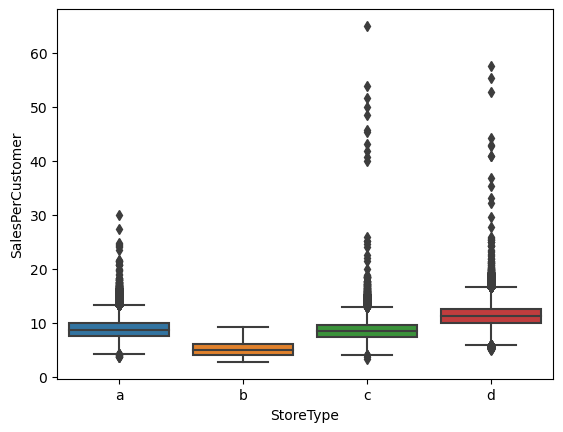

In [18]:
sns.boxplot(data=df_train_store, x='StoreType', y='SalesPerCustomer')
plt.savefig(os.path.join(IMG_PATH, 'storetypes_sales-pro-customer-je-storetype.png'))

#### StoreTypes - zeitliche Trends

##### Sales nach Jahr, Monat und StoreType

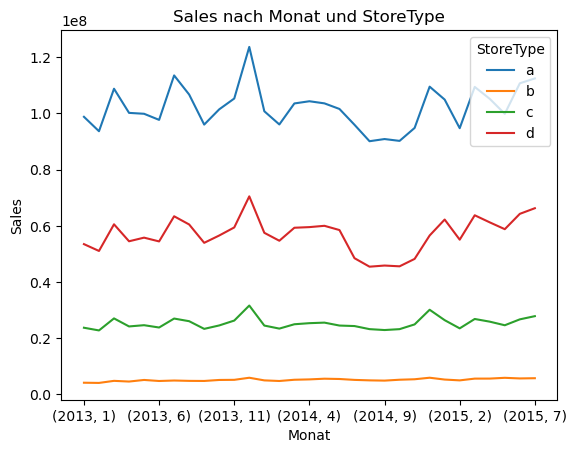

In [19]:
df_train_store.groupby(['Year', 'Month', 'StoreType'])['Sales'].sum().unstack().plot(kind='line')
plt.title('Sales nach Monat und StoreType')
plt.xlabel('Monat')
plt.ylabel('Sales')
plt.show()

##### Sales Timeline nach Jahr, Woche und StoreType

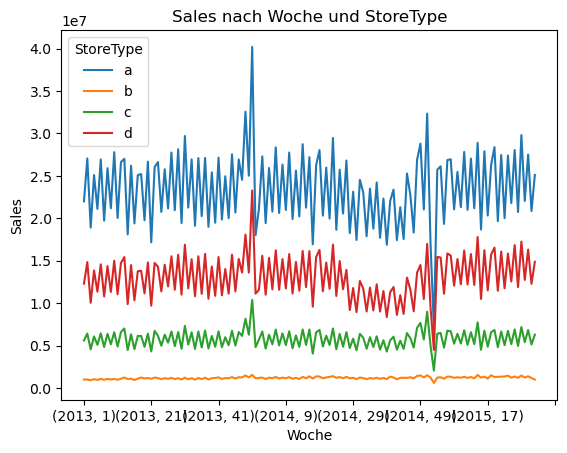

In [20]:
df_train_store.groupby(['Year', 'WeekOfYear', 'StoreType'])['Sales'].sum().unstack().plot(kind='line')
plt.title('Sales nach Woche und StoreType')
plt.xlabel('Woche')
plt.ylabel('Sales')
plt.show()

##### Sales, Customer & SalesPerCustomer monatlicher Trend je StoreType

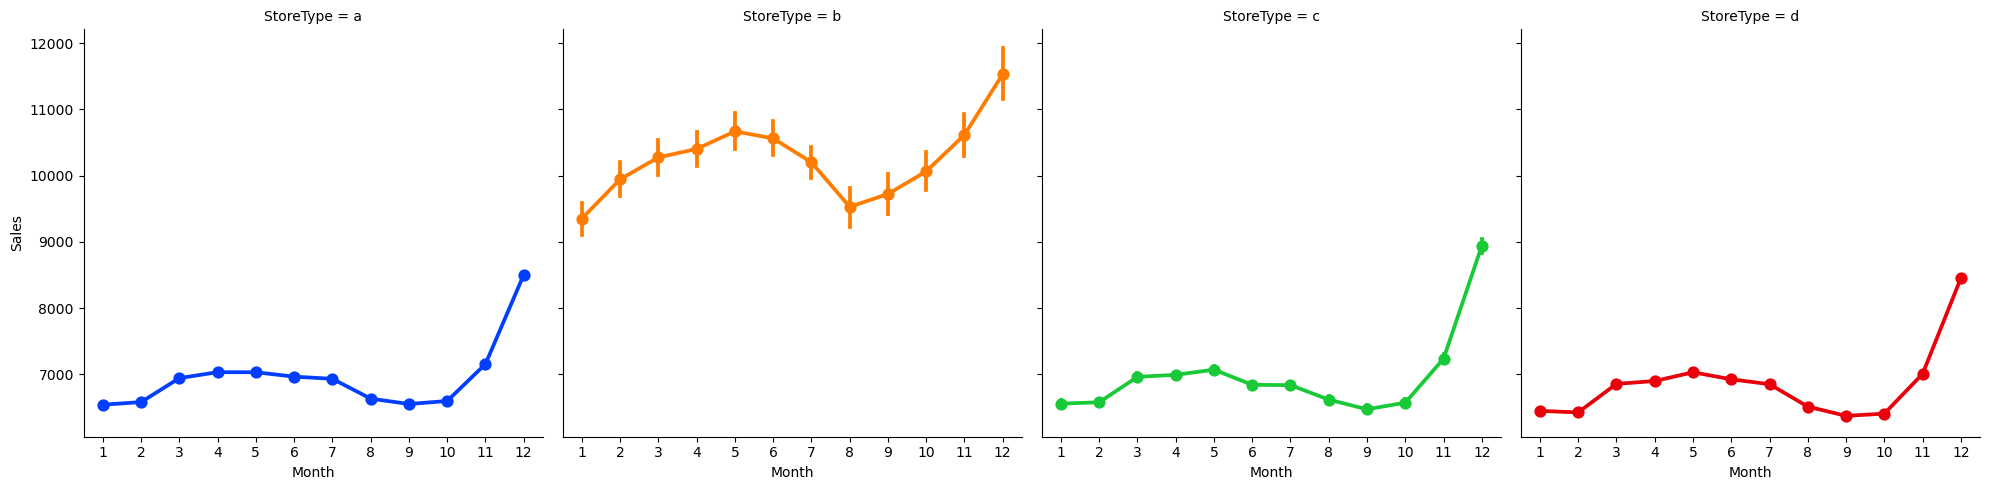

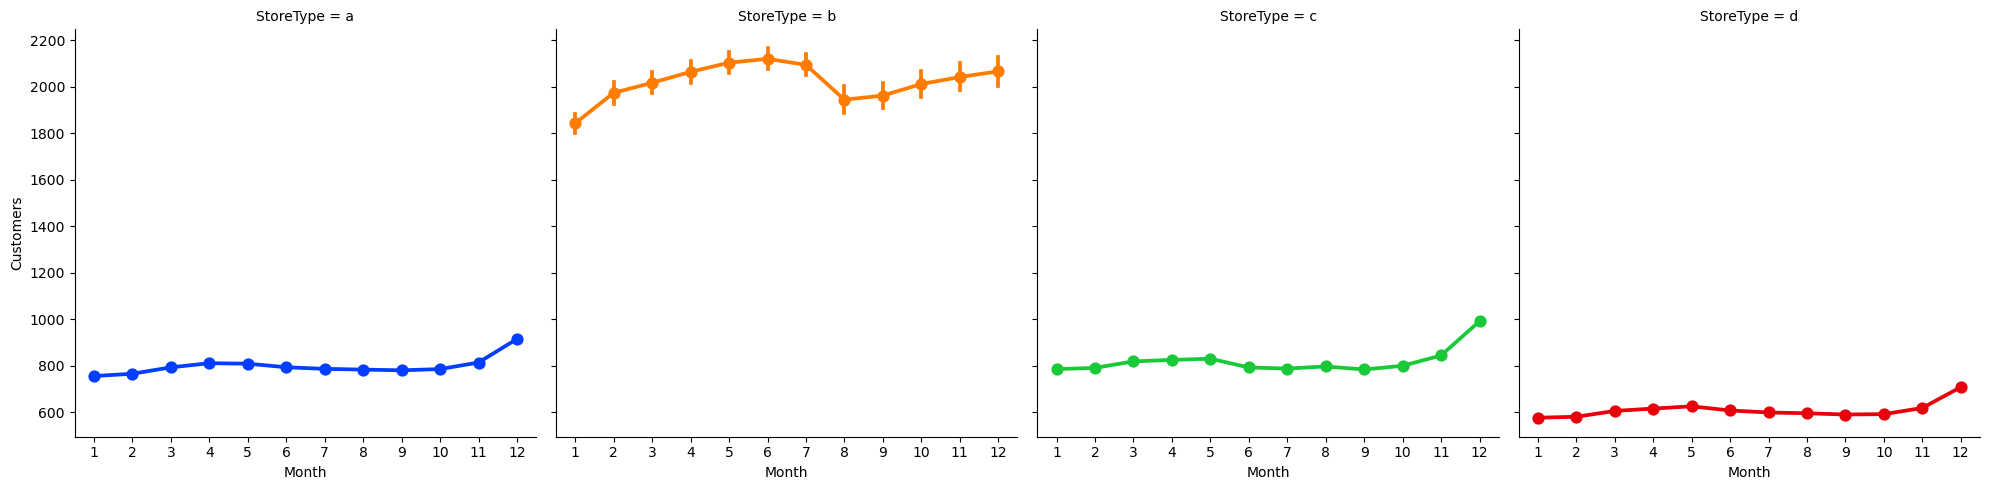

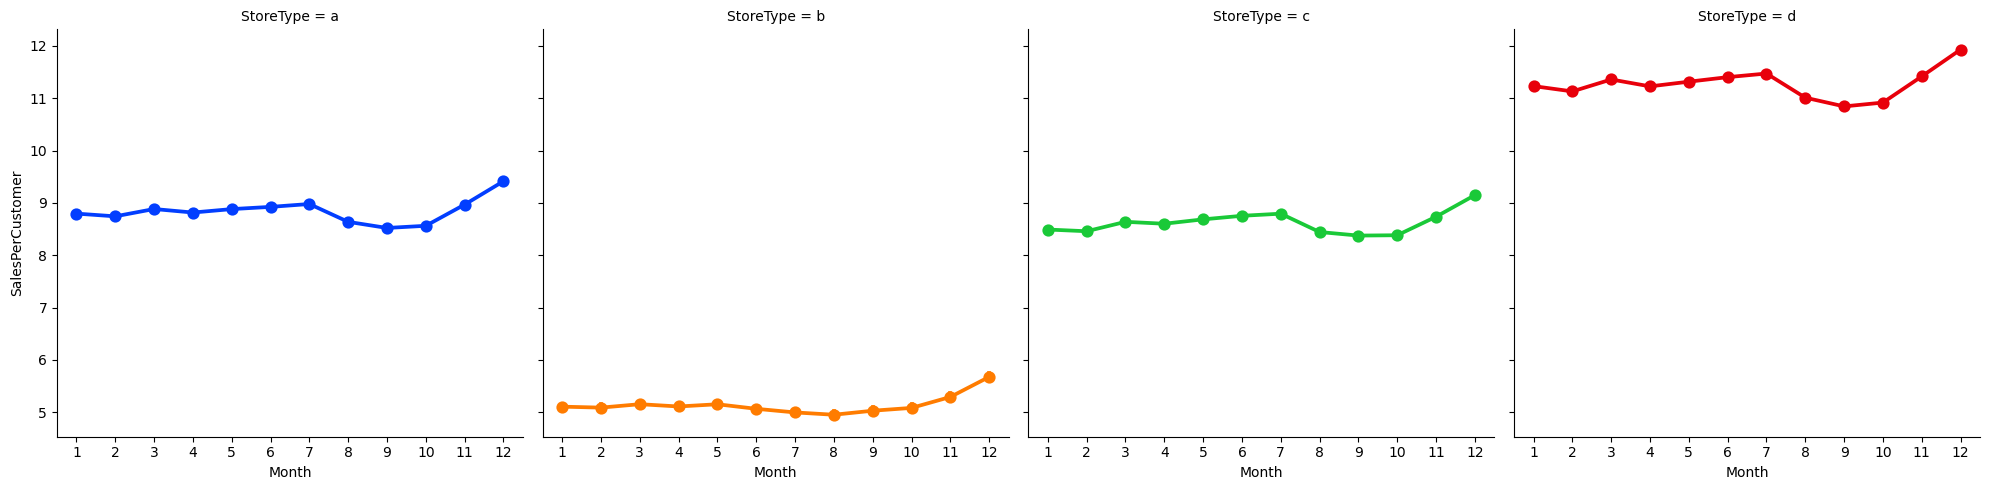

In [21]:
sns.catplot(data=df_train_store, x='Month', y='Sales',
            col='StoreType',
            palette='bright',
            hue='StoreType',
            kind='point'
           )

sns.catplot(data=df_train_store, x='Month', y='Customers',
            col='StoreType',
            palette='bright',
            hue='StoreType',
            kind='point'
           )

sns.catplot(data=df_train_store, x='Month', y='SalesPerCustomer',
            col='StoreType',
            palette='bright',
            hue='StoreType',
            kind='point'
           )

##### Sales monatlicher Trend aufgesplittet nach Jahren und StoreType

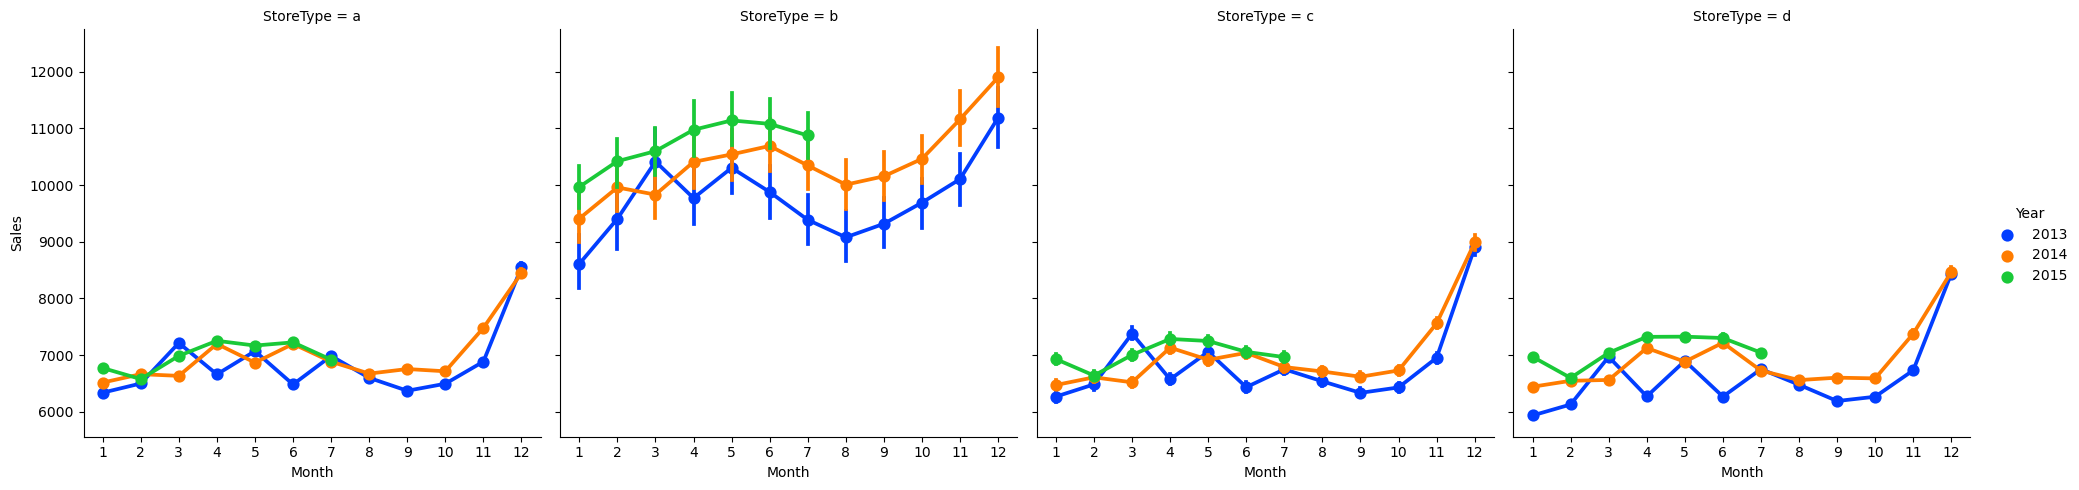

In [22]:
sns.catplot(data=df_train_store, x='Month', y='Sales',
            col='StoreType',
            palette='bright',
            hue='Year',
            kind='point'
            )

##### Sales wöchentlicher Trend und StoreType

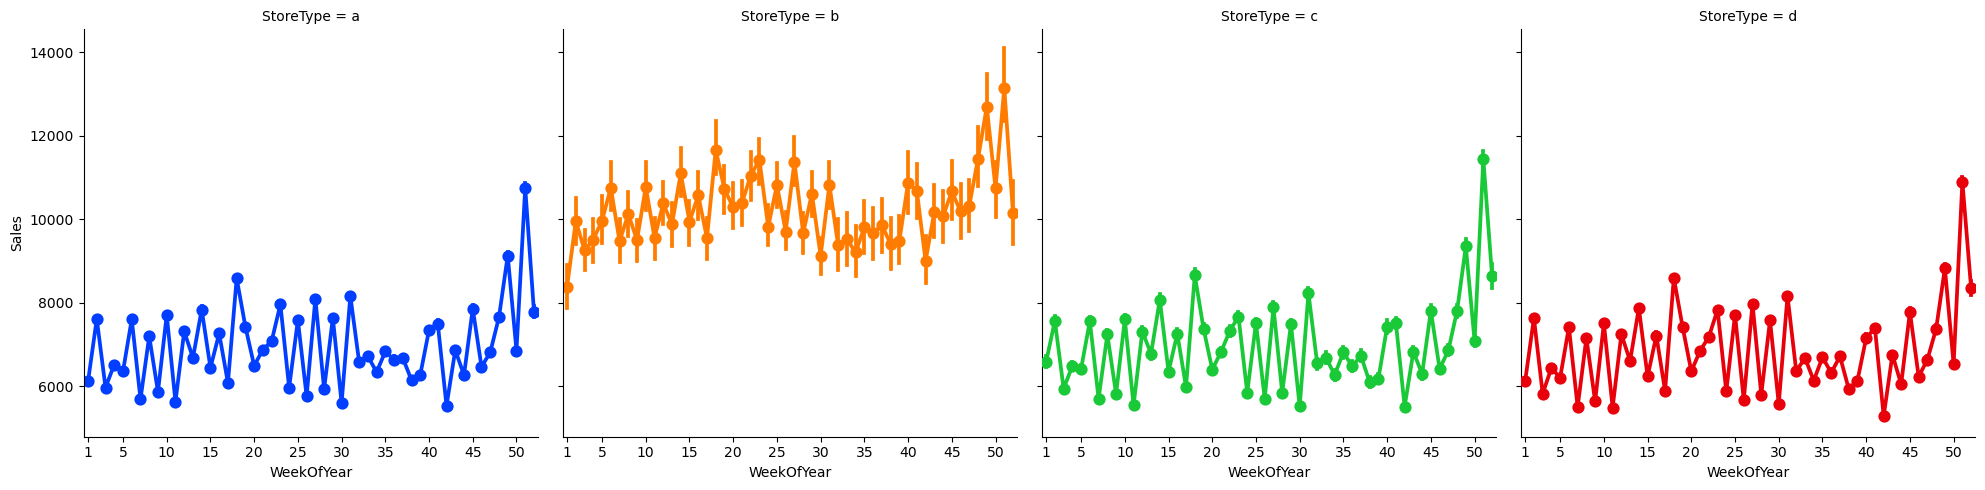

In [23]:
# Wird für die Anzeige der X-Achse verwendet (um nicht jeden Monat anzuzeigen)
x_ticks = [0, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49]

g = sns.catplot(data=df_train_store, x='WeekOfYear', y='Sales',
                col='StoreType',
                palette='bright',
                hue='StoreType',
                kind='point'
                )

# Legt die Achseneinteilung fest
for ax in g.axes.flatten():
    ax.set_xticks(x_ticks)

plt.show()

#### StoreTypes - nach Wochentag

##### Sales nach DayOfWeek und Storetype

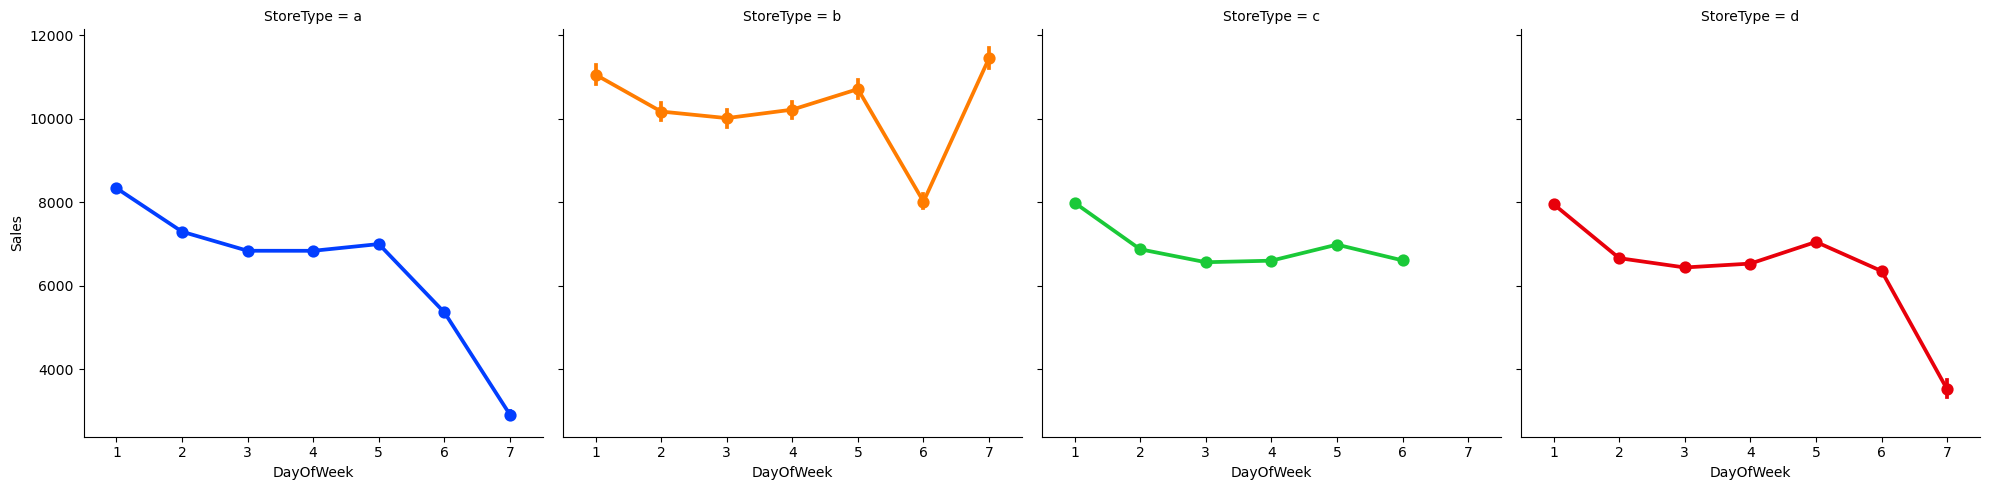

In [24]:
sns.catplot(data=df_train_store, x='DayOfWeek', y='Sales',
            col='StoreType',
            palette='bright',
            hue='StoreType',
            kind='point'
           )

##### Sales nach Monat, DayOfWeek und Storetype

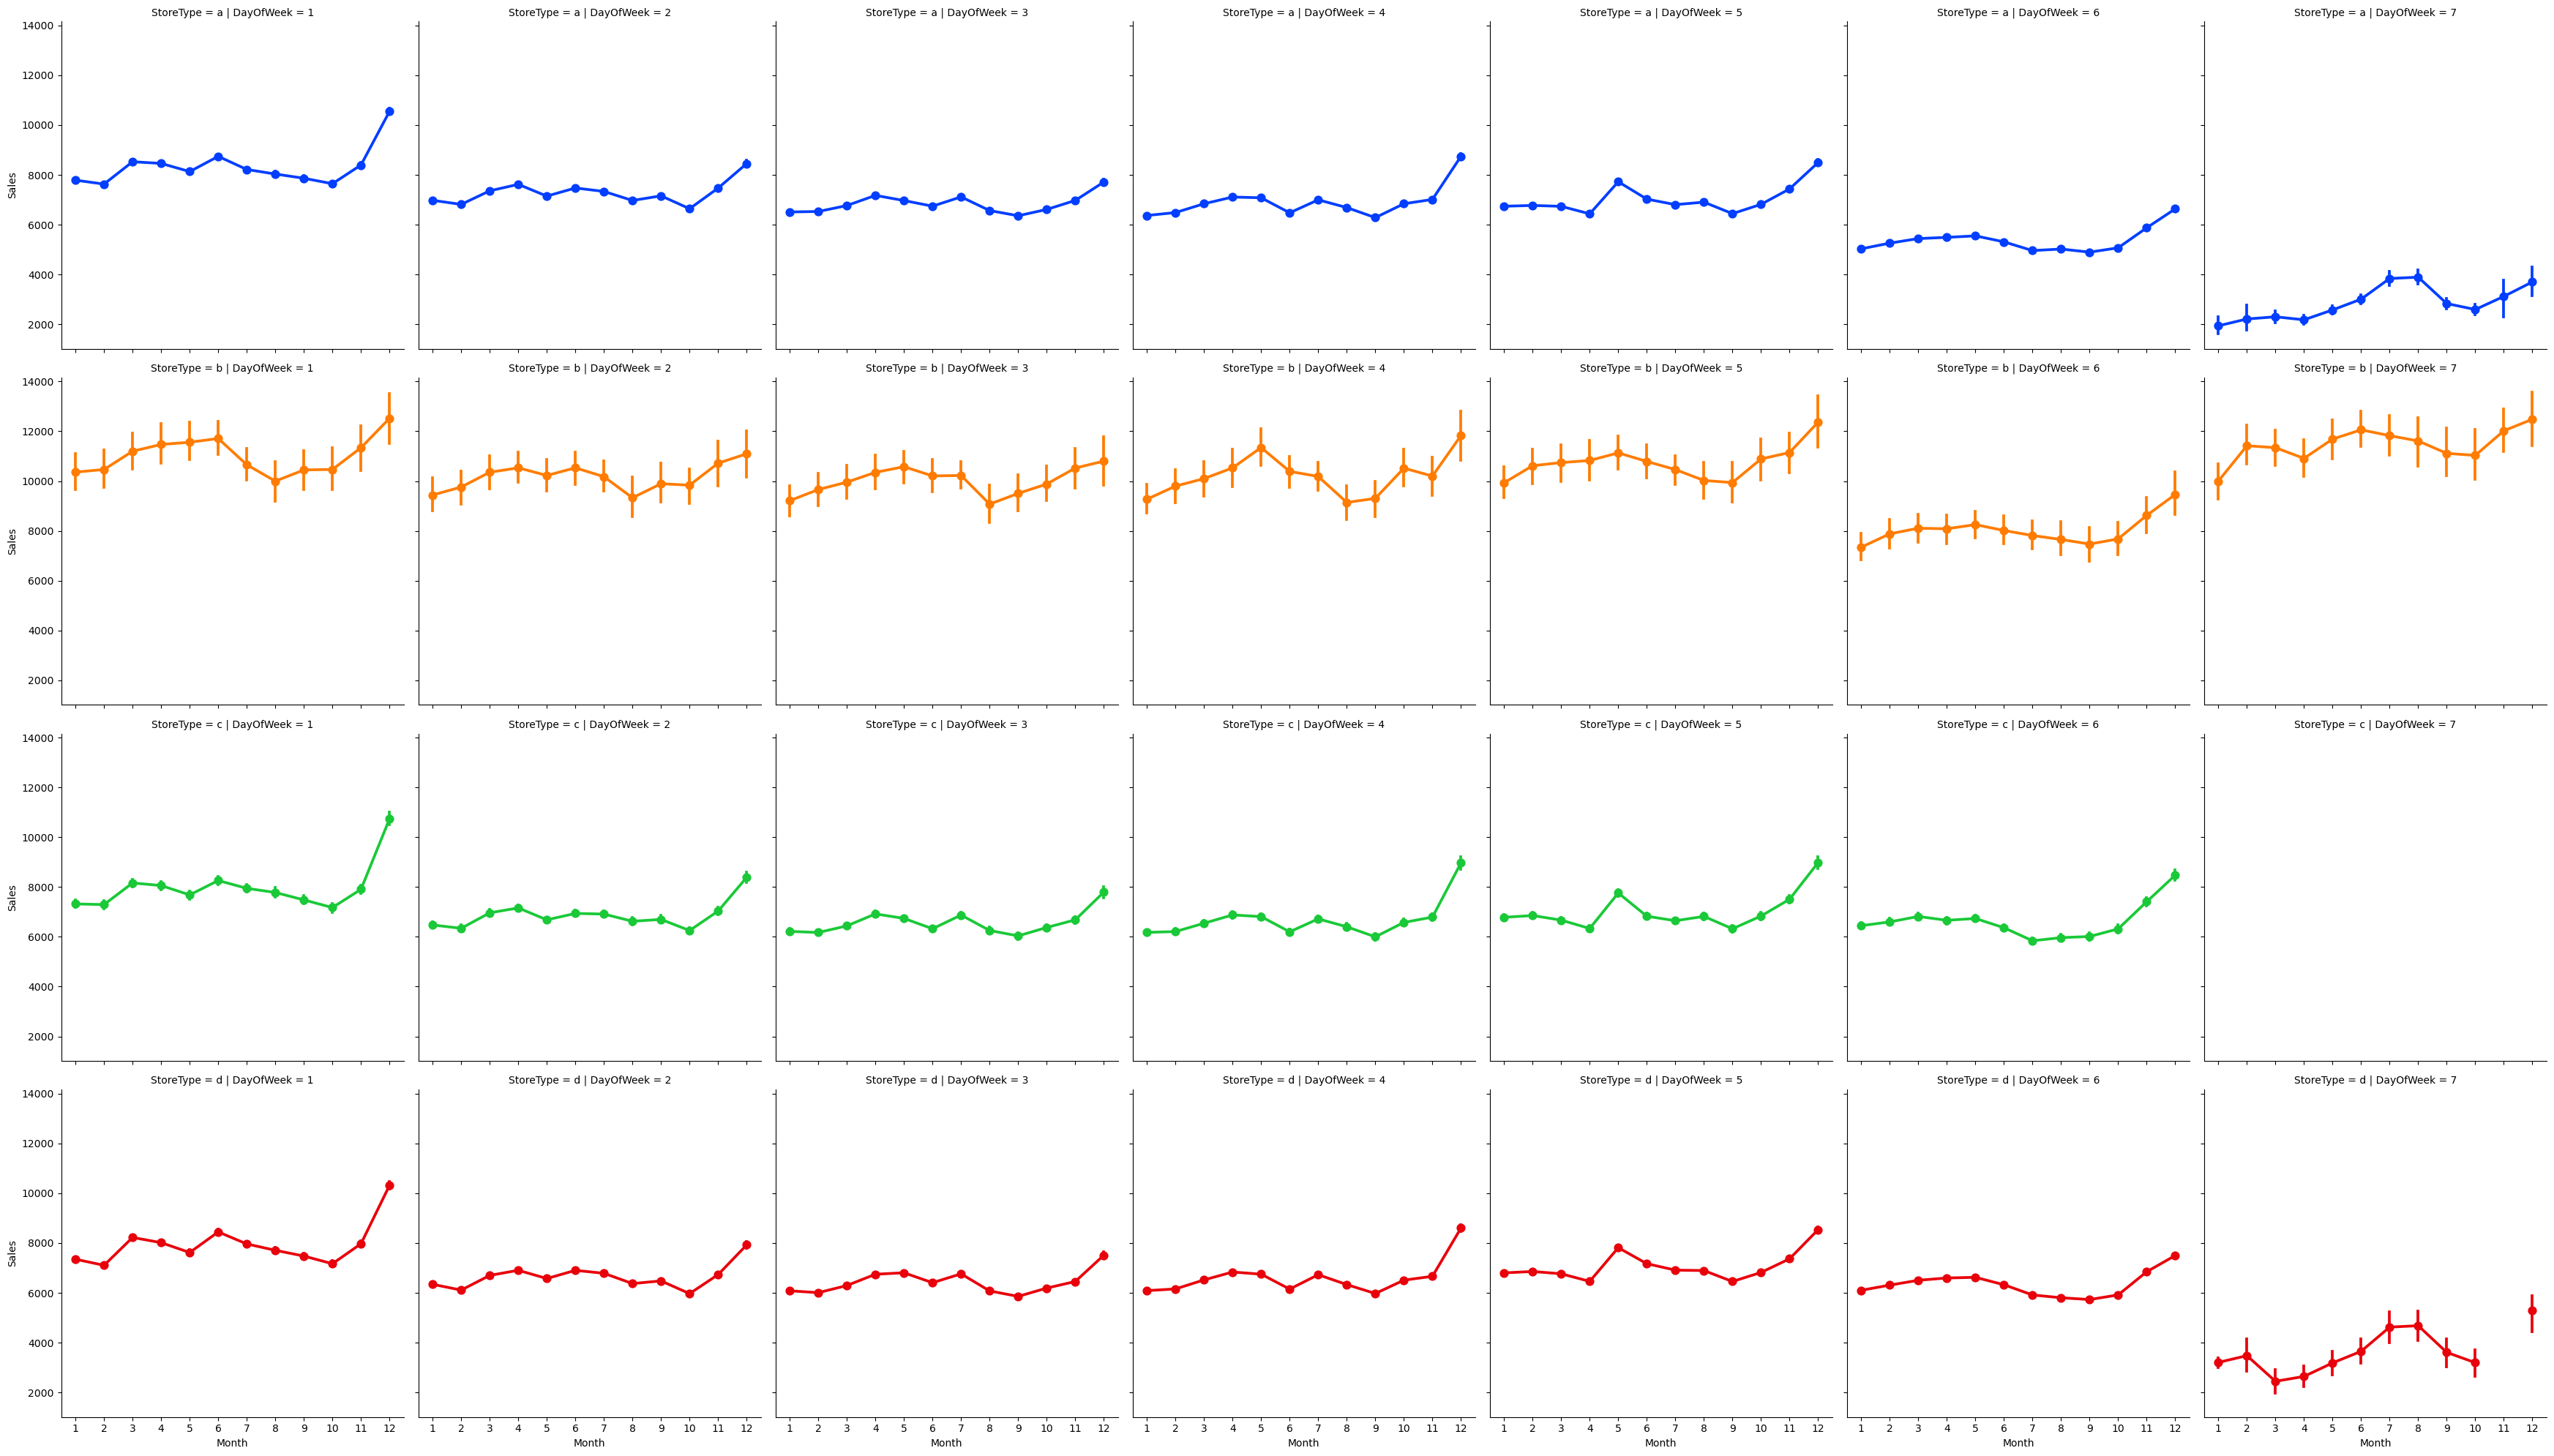

In [25]:
sns.catplot(data=df_train_store, x='Month', y='Sales',
            col='DayOfWeek',
            palette='bright',
            hue='StoreType',
            row="StoreType",
            kind='point'
           )

### Assortment

In [26]:
df_train_store.groupby('Assortment')[['Assortment', 'Sales']].describe()

Sales                                                    \
               count         mean          std     min     25%     50%   
Assortment                                                               
a           444875.0  6621.523057  2972.050174    46.0  4611.0  6082.0   
b             8209.0  8642.503594  3803.116031  1580.0  5606.0  8088.0   
c           391254.0  7300.843547  3183.849717   133.0  5156.0  6675.0   

                              
                75%      max  
Assortment                    
a            8000.0  38722.0  
b           11271.0  22137.0  
c            8703.0  41551.0

##### Sales, Customer & SalesPerCustomer nach DayOfWeek und Assortment

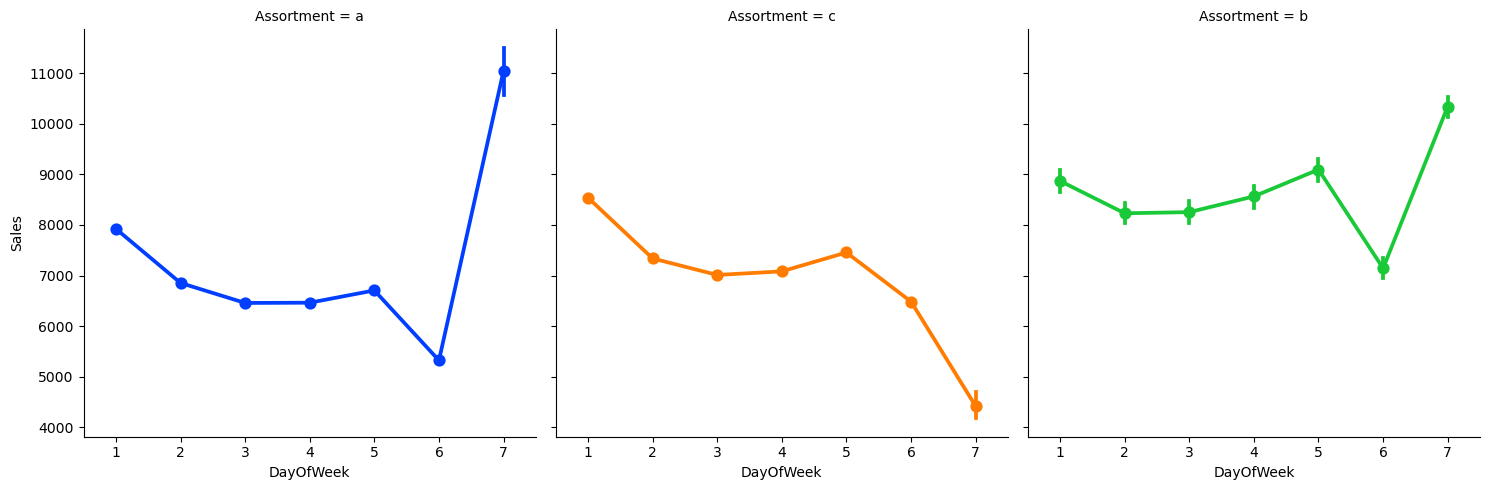

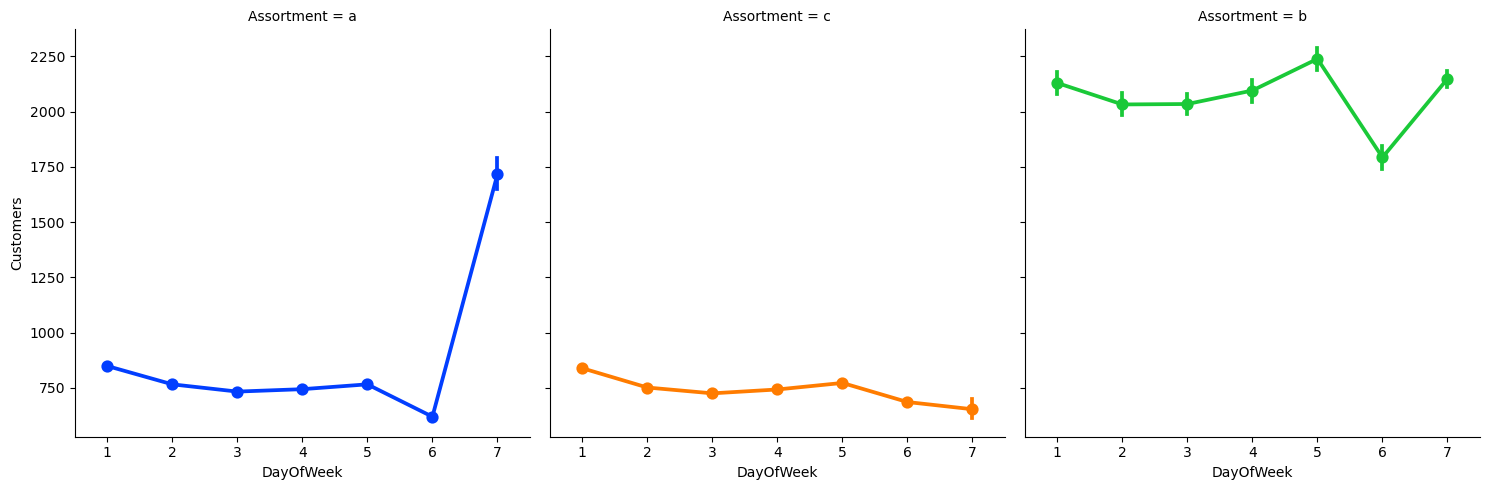

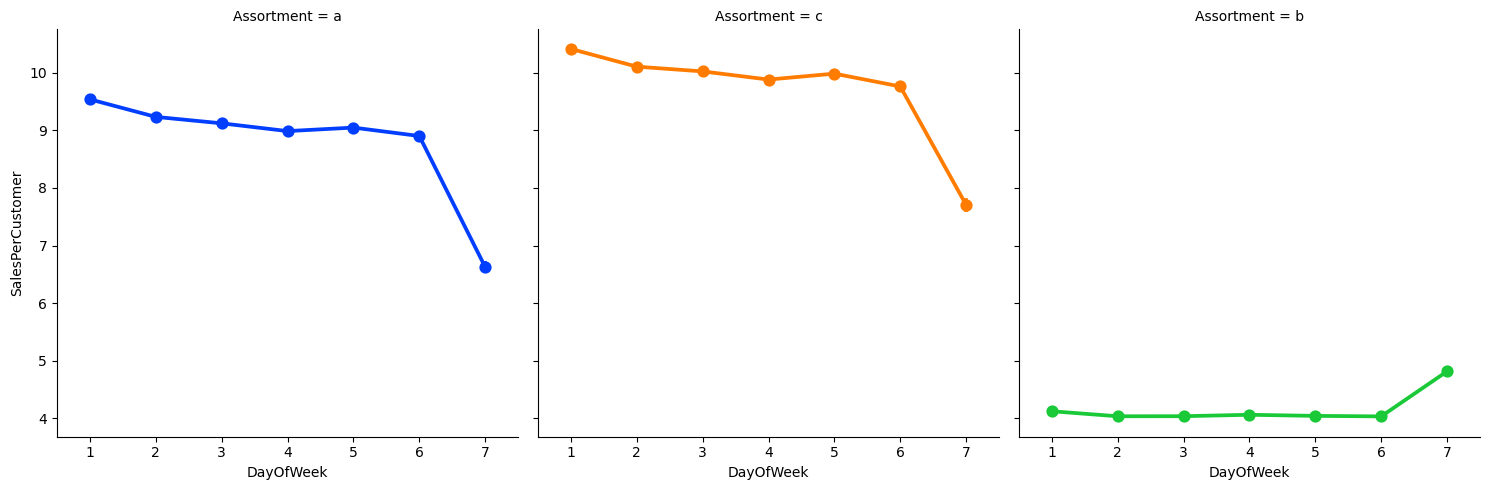

In [27]:
sns.catplot(data=df_train_store, x='DayOfWeek', y='Sales',
            col='Assortment',
            palette='bright',
            hue='Assortment',
            kind='point'
            )

sns.catplot(data=df_train_store, x='DayOfWeek', y='Customers',
            col='Assortment',
            palette='bright',
            hue='Assortment',
            kind='point'
            )

sns.catplot(data=df_train_store, x='DayOfWeek', y='SalesPerCustomer',
            col='Assortment',
            palette='bright',
            hue='Assortment',
            kind='point'
            )

##### Sales, Customer & SalesPerCustomer pro Monat je Assortment

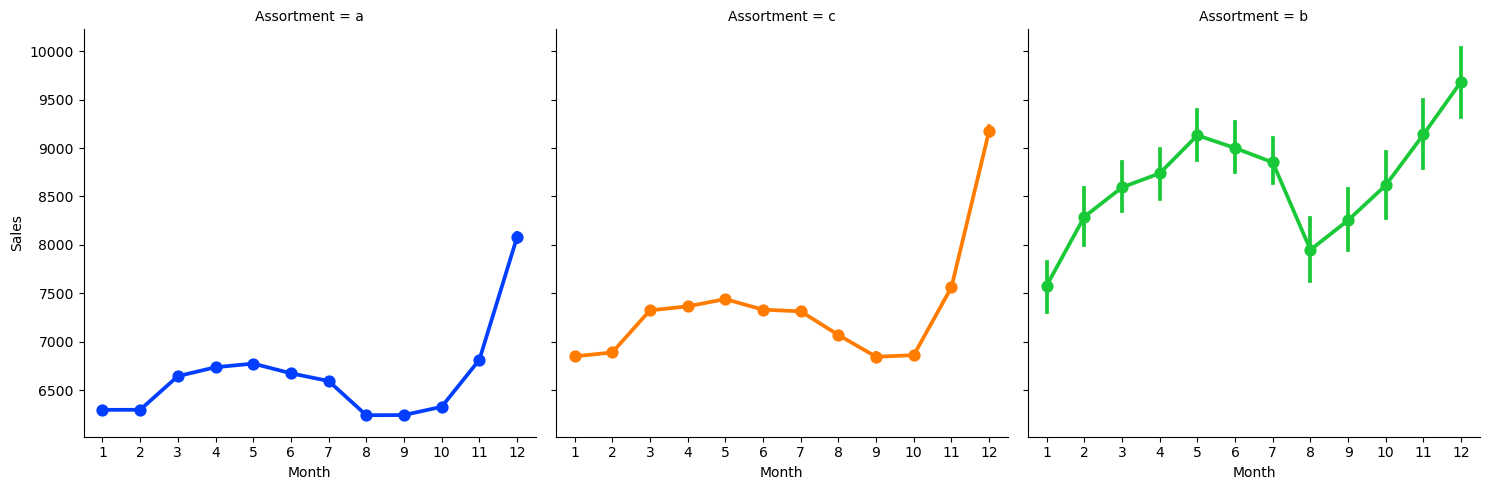

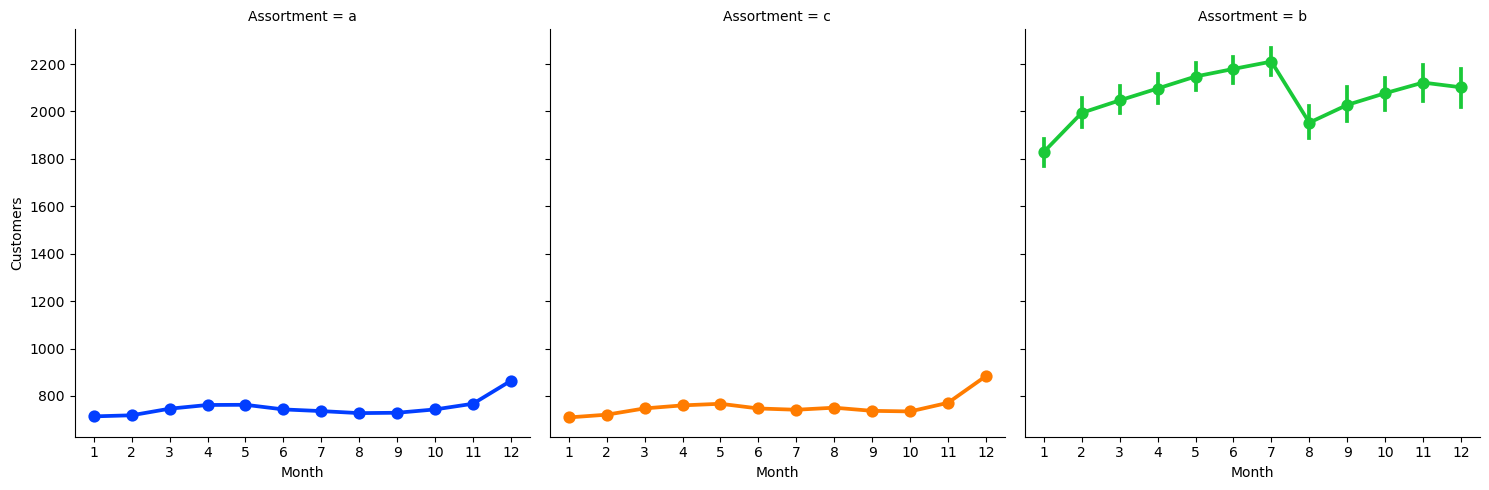

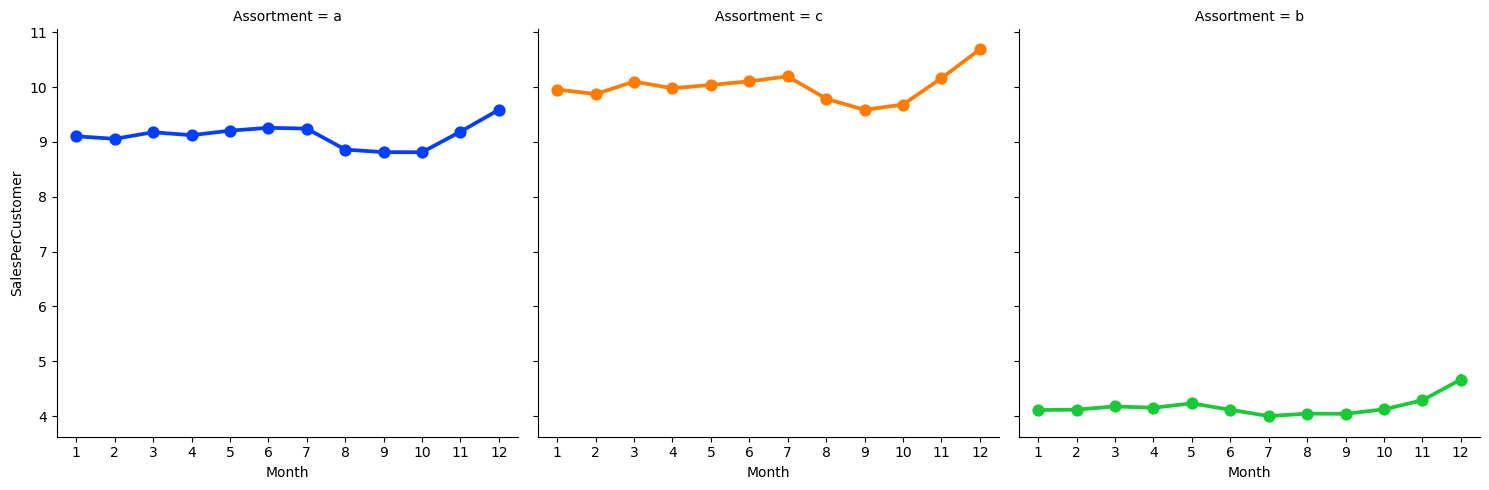

In [28]:
sns.catplot(data=df_train_store, x='Month', y='Sales',
            col='Assortment',
            palette='bright',
            hue='Assortment',
            kind='point'
           )

sns.catplot(data=df_train_store, x='Month', y='Customers',
            col='Assortment',
            palette='bright',
            hue='Assortment',
            kind='point'
           )

sns.catplot(data=df_train_store, x='Month', y='SalesPerCustomer',
            col='Assortment',
            palette='bright',
            hue='Assortment',
            kind='point'
           )

### Promo

##### SalesPerCustomer nach Monat, Storetype und Promo / Promo2

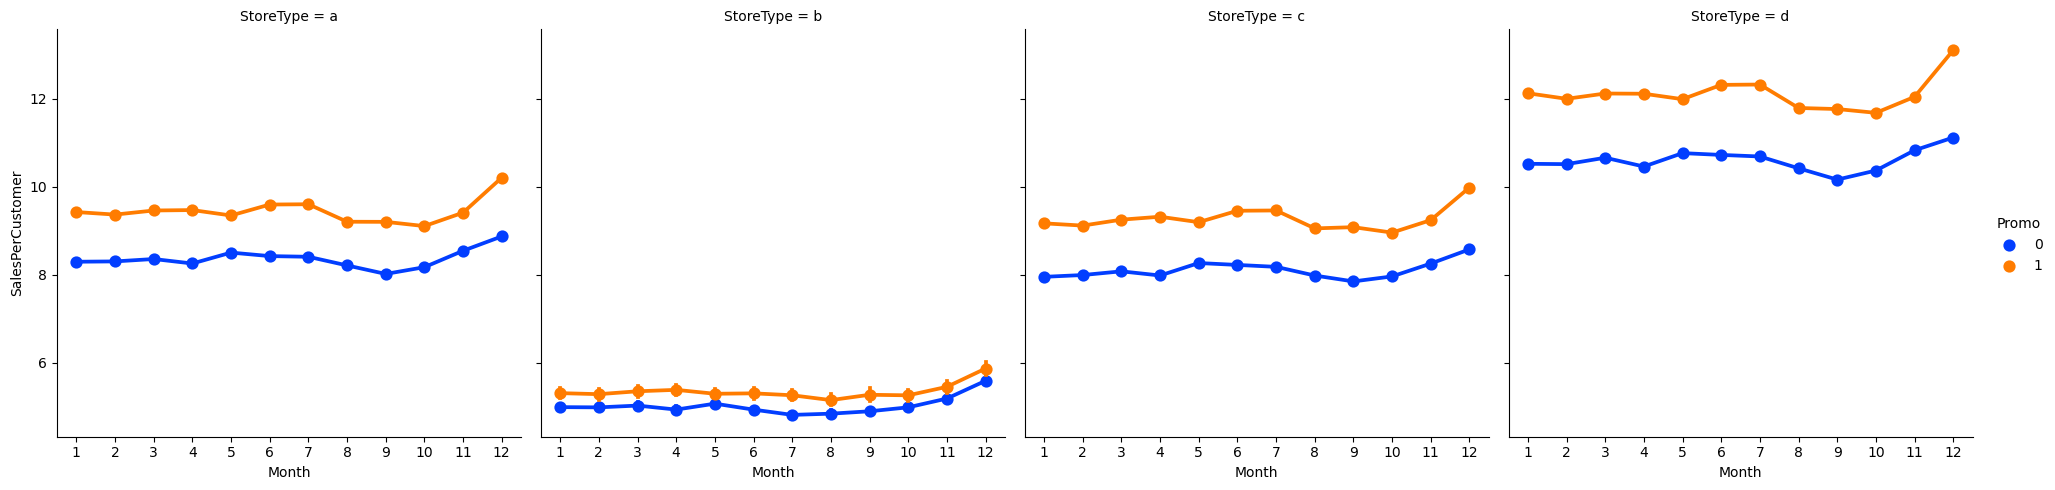

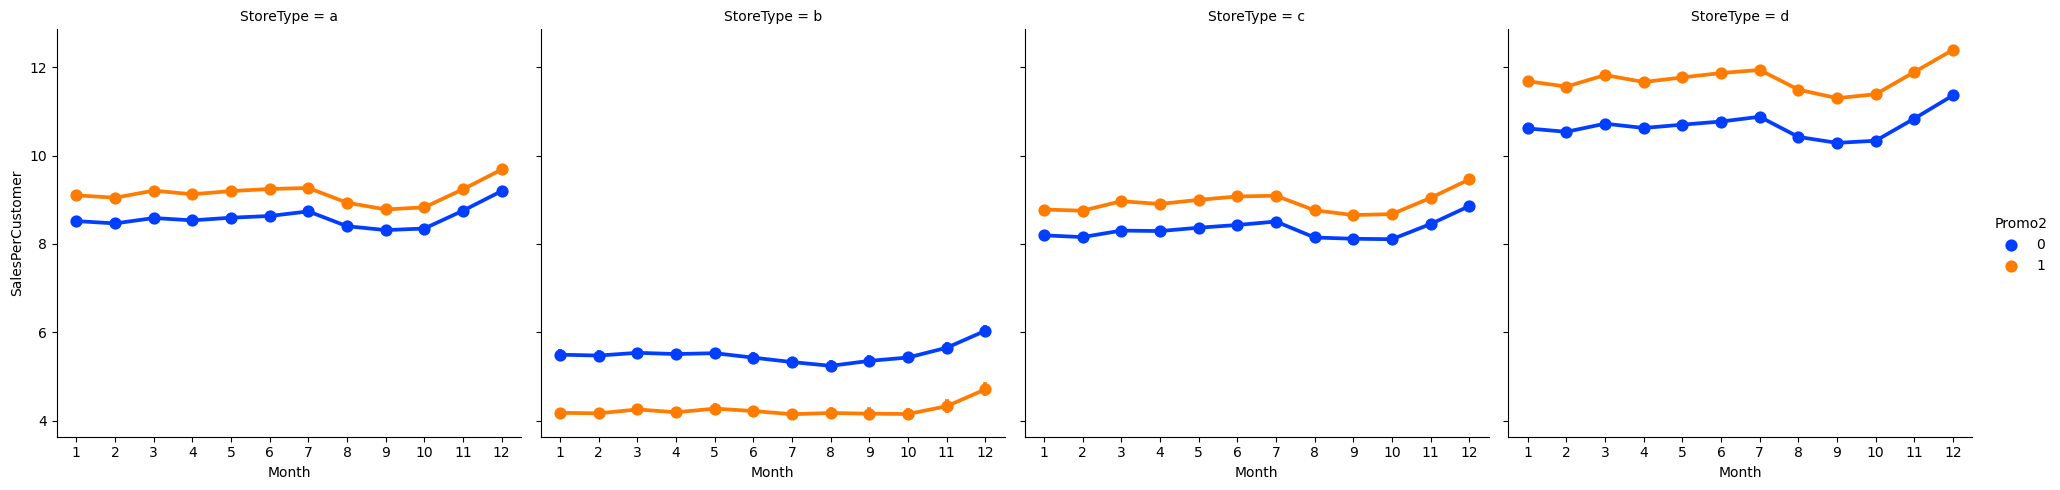

In [29]:
sns.catplot(data=df_train_store, x='Month', y='SalesPerCustomer',
            col='StoreType',
            palette='bright',
            hue='Promo',
            kind='point'
           )

sns.catplot(data=df_train_store, x='Month', y='SalesPerCustomer',
            col='StoreType',
            palette='bright',
            hue='Promo2',
            kind='point'
           )

##### SalesPerCustomer nach DayOfWeek, Storetype und Promo / Promo2

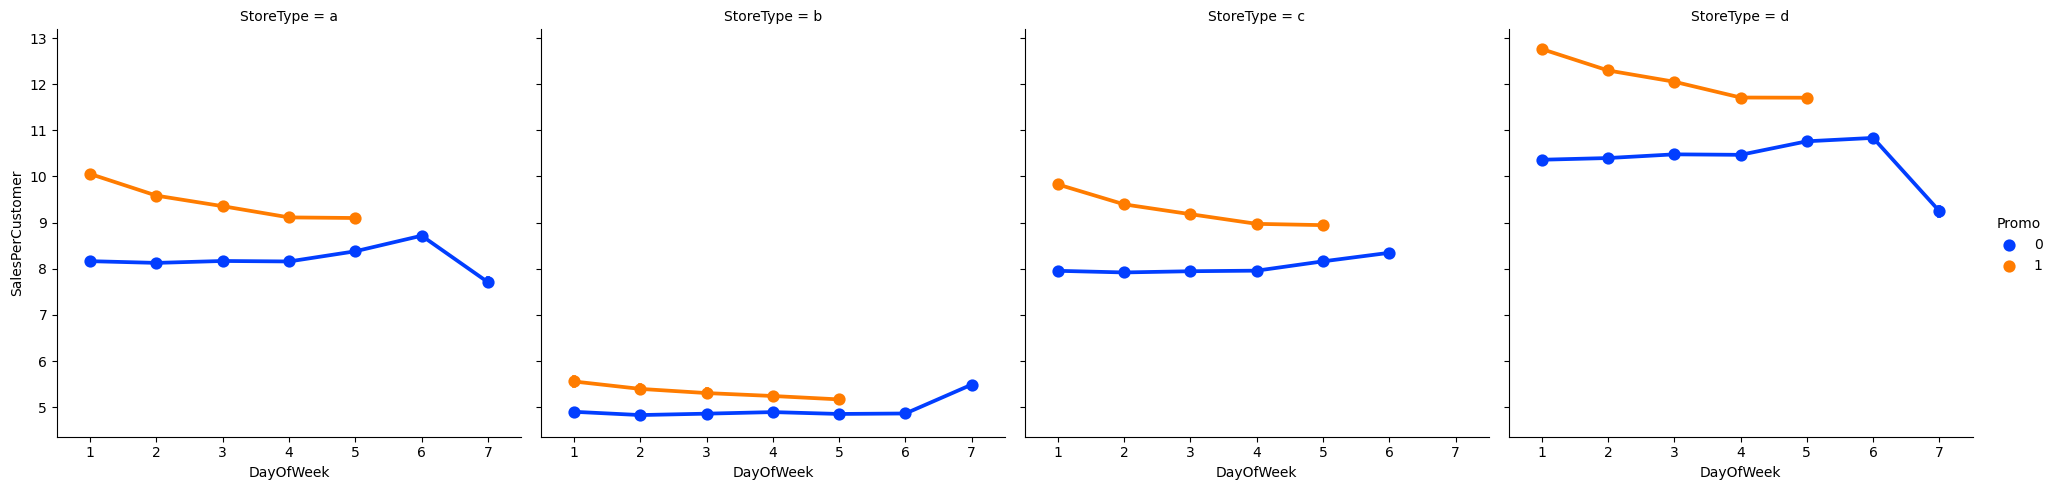

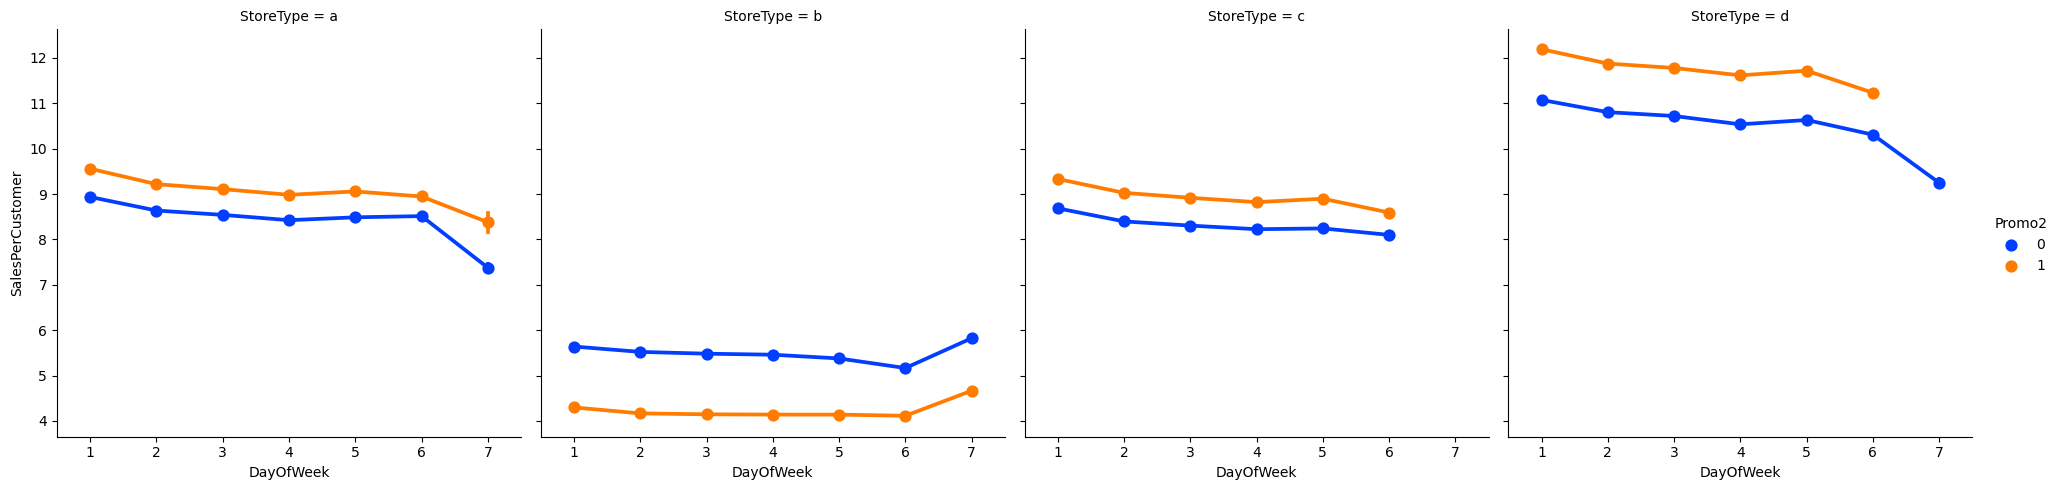

In [30]:
sns.catplot(data=df_train_store, x='DayOfWeek', y='SalesPerCustomer',
            col='StoreType',
            palette='bright',
            hue='Promo',
            kind='point'
           )

sns.catplot(data=df_train_store, x='DayOfWeek', y='SalesPerCustomer',
            col='StoreType',
            palette='bright',
            hue='Promo2',
            kind='point'
           )

## 3.4. EDA Zusammenfassung
  - Die Filialen sind in der Regel von Montag bis Samstag geöffnet und am Sonntag geschlossen
  - 


  - Es besteht eine starke Korrelation zwischen der Anzahl an Kunden und dem Umsatz
  - Storetype B generiert den höchsten Umsatz pro Tag
  - Storetype B generiert den niedrigsten Umsatz pro Kunden
  - Storetype D generiert den höchsten Umsatz pro Kunden
  - Storetype A generiert den größten Gesamtumsatz, hat aber auch die meisten Kunden
  - Storetype C ist an Sonntagen geschlossen
  - Storetype D ist nur im November an Sonntagen geschlossen
  -
  - Im Dezember gibt es (unabhängig vom Storetype) ein starkes Umsatzwachstum
  - 
  - 
  - 

Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount.
Customers tends to buy more on Modays when there's one promotion (Promo) and on Sundays when there's no promotion at all (both Promo and Promo1 are equal to 0)


# 4. Zeitreihenanalyse und Forecasting
In diesem Kapitel wird eine Zeitreihenanalyse mit "seasonal_decompose" sowie 
und ein Forecast der Verkaufsdaten von Rossmann durchgeführt. Dabei werden sowohl klassische als auch moderne Zeitreihenmodelle verwendet.

## Methode Modellierung inkl. Theorie
Für die Zeitreihenanalyse werden verschiedene Modelle verwendet, darunter:

- Naive Ansatz: Bei diesem Ansatz wird der Verkauf des aktuellen Tages als Vorhersage für den nächsten Tag verwendet. Der naive Ansatz eignet sich gut als Basislinie, da er schnell berechnet werden kann und als einfaches Modell dient.
- Durchschnittsmethode: Bei dieser Methode wird der Durchschnitt der Verkaufszahlen über eine bestimmte Zeitperiode als Vorhersage für den nächsten Tag verwendet. Diese Methode kann nützlich sein, wenn es keine klaren Trends oder saisonalen Muster gibt.
- Exponentielle Glättung: Die exponentielle Glättung ist eine Methode, bei der ein gewichtetes Durchschnittsverfahren angewendet wird, um eine Prognose zu erstellen. Diese Methode ist besonders nützlich bei Daten mit saisonalen Mustern oder Trends.
- ARIMA-Modell: Das autoregressive integrierte gleitende Durchschnittsmodell (ARIMA) ist ein klassisches statistisches Modell, das zur Modellierung von Zeitreihendaten verwendet wird. Es basiert auf der Annahme, dass vergangene Werte eine Vorhersage zukünftiger Werte ermöglichen.
- Prophet: Prophet ist ein auf Facebook entwickeltes Modell, das speziell für die Vorhersage von Zeitreihendaten entwickelt wurde. Es basiert auf einer additiven Regressionsanalyse, die saisonale Muster, Trends und Ausreißer berücksichtigt.

## Datenaufbereitung
Um die Modelle anwenden zu können, müssen die Daten vorbereitet werden. Zunächst werden Daten, die nicht relevant sind oder nicht zur Vorhersage beitragen, entfernt. Nicht relevante Daten sind beispielsweise die Einträge, an denen die Filiale geschlossen war und kein Umsatz generiert wurde. Diese Daten wurden während der EDA bereits entfernt, demzufolge muss dies im Folgenden nicht mehr gemacht werden. Weiterhin müssen fehlende Werte im Datensatz entfernt oder ersetzt werden. Die fehlenden Werte der Spalte "CompetitionDistance", welche die Entfernung zum nächstgelegenen Konkurrenzgeschäft angibt, werden durch den Durchschnittswert dieser Spalte ersetzt. Alle anderen NULL-Werte sind in Spalten mit Zahlen und werden durch "0" ersetzt. 

In [31]:
df_train_store.isnull().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
Date                              0
SalesPerCustomer                  0
dtype: int64

In [32]:
df_train_store['CompetitionDistance'].fillna(df_train_store['CompetitionDistance'].median(), inplace=True)
df_train_store['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
df_train_store['CompetitionOpenSinceYear'].fillna(0, inplace=True)
df_train_store['Promo2SinceWeek'].fillna(0, inplace=True)
df_train_store['Promo2SinceYear'].fillna(0, inplace=True)
df_train_store['PromoInterval'].fillna(0, inplace=True)

In [33]:
df_train_store.isnull().sum()


Store                        0
DayOfWeek                    0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Year                         0
Month                        0
Day                          0
WeekOfYear                   0
Date                         0
SalesPerCustomer             0
dtype: int64

## 4.1. Zeitreihenanalyse mit seasonal_decompose  

Im nachfolgenden Code wird eine saisonale Zeitreihenanalyse durchgeführt, um die verschiedenen Komponenten der Verkaufsdaten nach StoreType zu untersuchen. Hierfür wird die Bibliothek "statsmodels.tsa.seasonal" mit der Funktion "seasonal_decompose" verwendet. Die "seasonal_decompose"-Funktion zerlegt eine Zeitreihe in ihre Komponenten, um Trends und saisonale Muster zu identifizieren. Folgende Komponenten werden analysiert und dargestellt:  
1. Trendkomponente: Die Trendkomponente zeigt den übergeordneten Trend der Zeitreihe an, d.h. die langfristige Entwicklung oder Veränderung der Verkaufswerte. Positive Werte deuten auf einen aufwärtsgerichteten Trend hin, während negative Werte auf einen abwärtsgerichteten Trend hinweisen. Ein flacher Trend um null deutet auf fehlenden oder geringen Trend hin.  

2. Saisonale Komponente: Die saisonale Komponente zeigt periodische Muster oder saisonale Schwankungen in den Daten an. Sie kann jährliche, monatliche, wöchentliche oder andere wiederkehrende Muster umfassen, abhängig von der Periodizität der Daten. Die saisonale Komponente wird oft als Schätzung der saisonalen Effekte in den Daten verwendet und kann helfen, saisonale Muster zu verstehen oder saisonale Anpassungen vorzunehmen.  

3. Residualkomponente: Die Residualkomponente oder Restkomponente enthält die nicht erklärte Variation oder das Rauschen in den Daten, nachdem der Trend und die saisonalen Muster entfernt wurden. Sie kann als Abweichung von den erwarteten Werten oder als zufällige Variation betrachtet werden. Eine hohe Residualkomponente kann auf unerklärte Strukturen oder Ausreißer hinweisen, während eine niedrige Residualkomponente auf ein gut modelliertes Verhalten hinweisen kann.  

Der Code aggregiert im ersten Schritt das DataFrame mit den Verkaufsdaten nach "StoreType" und "Date". 
Im Anschluss wird ein neues DataFrame erstellt, der die aggregierten Verkaufsdaten enthält, mit "Date" als Index und "Sales" als Wert, die jeweils einem bestimmten "StoreType" zugeordnet sind.

Als nächstes wird der DataFrame auf eine tägliche Frequenz umgestellt und dann wird eine Schleife durch alle Spalten im DataFrame durchgeführt. Für jeden StoreType wird die "seasonal_decompose"-Funktion aufgerufen, um die Zeitreihe der Verkaufsdaten in die Trend-, saisonale- und Restkomponenten zu zerlegen. Das Ergebnis wird grafisch dargestellt und mit "plt.show()" angezeigt.

C:\Users\dariu\AppData\Local\Temp\ipykernel_183816\1347585506.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df_train_store.groupby(['StoreType', 'Date']).sum().reset_index()


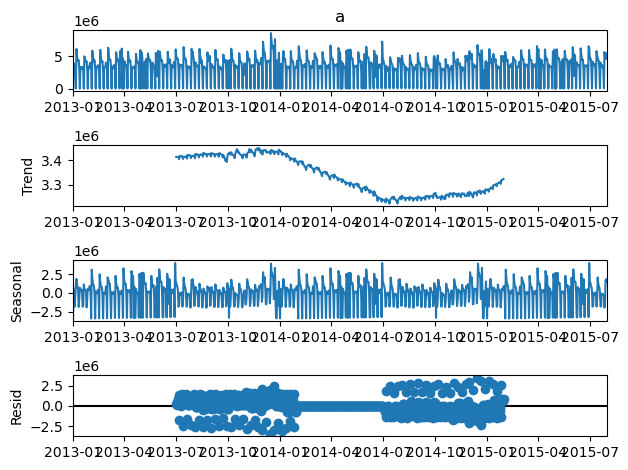

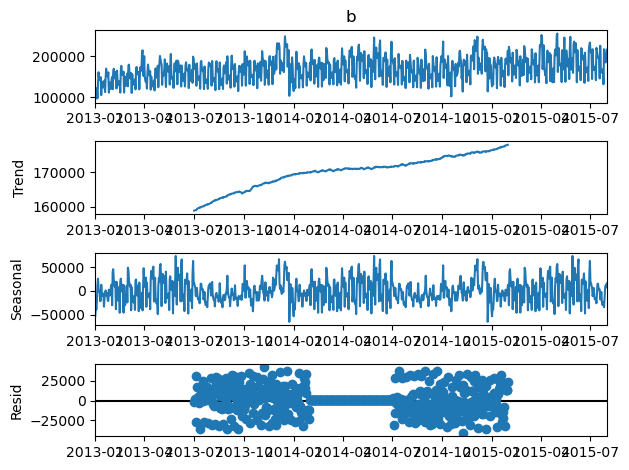

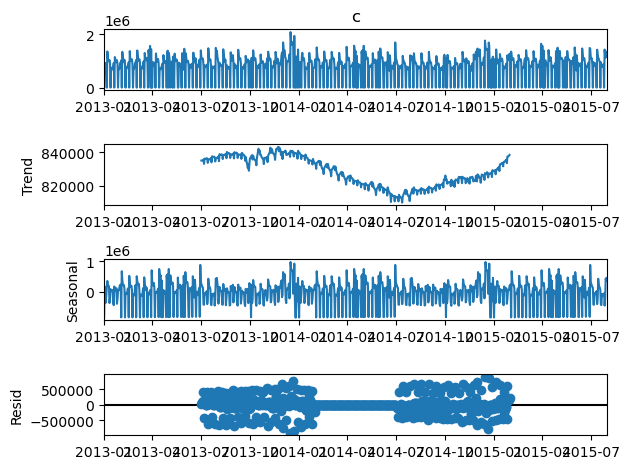

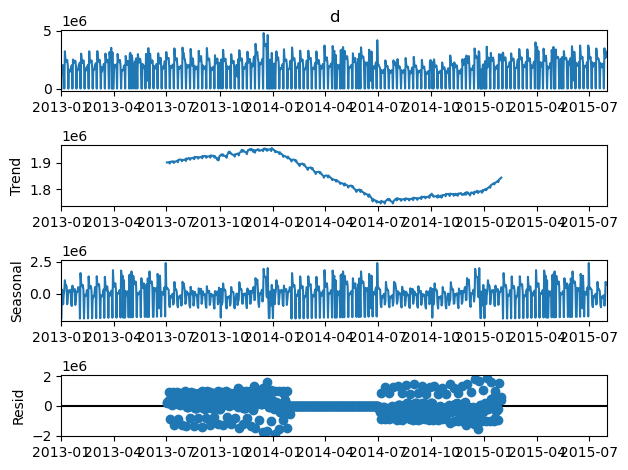

In [35]:
df_train_store['Date'] = pd.to_datetime(df_train_store[['Year', 'Month', 'Day']])
df_train_store = df_train_store.reset_index(drop=True)

df_grouped = df_train_store.groupby(['StoreType', 'Date']).sum().reset_index()
df_sales = df_grouped.pivot(index='Date', columns='StoreType', values='Sales')
df_sales = df_sales.resample('D').sum()

def seasonal_decompose_and_plot_additive(data, store_type):
    result = sm(data, model='additive', period=365)
    result.plot()
    filename = f'seasonal_decompose_additive_storetype-{store_type}.png'
    plt.savefig(os.path.join(IMG_PATH, filename))
    plt.show()

store_types = df_sales.columns.tolist()

for store_type in store_types:
    seasonal_decompose_and_plot_additive(df_sales[store_type], store_type)

## 4.2. Zeitreihenanalyse und Forecast mit Prophet
In diesem Abschnitt wird das Prophet-Modell angewendet, um einen Forecast für die Verkaufsdaten zu erstellen. Prophet wurde von Facebooks Data Science Team entwickelt und ist ein leistungsfähiges Modell für die Vorhersage von Zeitreihendaten, das speziell entwickelt wurde, um eine einfache und effektive Methode zu schaffen, die saisonale Muster und Trends aufweisen. Insbesondere sollten auch Anwender ohne umfangreiche Fachkenntnisse im Bereich der statistischen Zeitreihenanalyse in der Lage sein, das Modell anzuwenden und Ergebnisse zu erzielen. Das Modell basiert auf einer additiven Regressionsanalyse, die sowohl saisonale als auch nicht-saisonale Komponenten berücksichtigt.

Die nachfolgenden Codeabschnitte orientieren sich an dem "quick start guide" von prophet. Dieser ist unter folgendem Link zu finden: https://facebook.github.io/prophet/docs/quick_start.html.

### 4.2.1. Prophet Forecast-Beispiel anhand von einem Store
Im ersten Schritt wird eine Filial-ID ausgewählt, an welcher beispielhaft der Prophet Forecast durchgeführt wird. Hierzu wird für jeden StoreType eine Filial-ID ausgegeben, eine der IDs ausgewählt und die Verkaufsdaten für die Filiale in einem Liniendiagramm dargestellt. Anschließend wird das DataFrame, welches für den Forecast verwendet wird, vorbereitet. Hierbei ist zu beachten, dass die Spaltenbezeichnungen fest definierte Namen haben müssen: "ds" für das Datum und "y" für die Zielvariable, in diesem Fall die Sales. Zusätzlich wird das DataFrame absteigend sortiert und der index auf eine aufsteigende Zahlenfolge zurückgesetzt.

In [36]:
# Pro Storetype einen Store anzeigen
for store_type in df_train_store.StoreType.unique():
    print(store_type, ' - ', df_train_store[df_train_store.StoreType == store_type].Store.unique()[0])

a  -  558
b  -  1081
c  -  843
d  -  309


In [37]:
store_id = 558

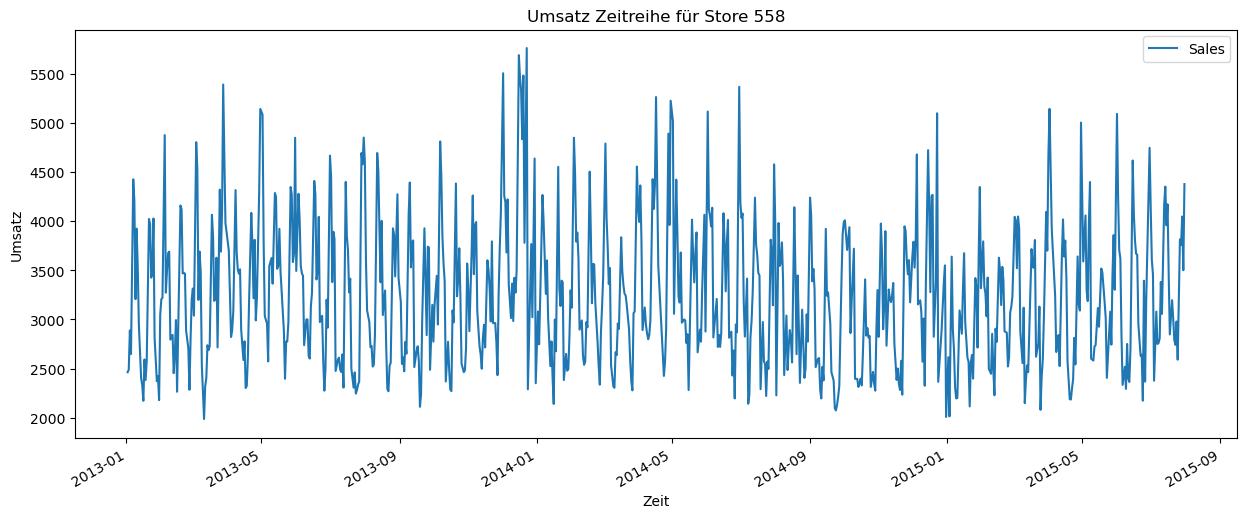

In [38]:
store = df_train_store[df_train_store.Store == store_id].loc[:, ['Date', 'Sales']].sort_values(by='Date').reset_index(drop=True)
store.plot(x='Date', y='Sales', figsize=(15,6))
plt.xlabel('Zeit')
plt.ylabel('Umsatz')
plt.title('Umsatz Zeitreihe für Store {}'.format(store_id))
plt.savefig(os.path.join(IMG_PATH, 'prophet_store_{}_actual_data'.format(store_id)))
plt.show()

In [39]:
df_prophet = df_train_store[df_train_store.Store == store_id].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
df_prophet.sort_values(by='Date', inplace=True)
df_prophet.reset_index(drop=True, inplace=True)

# Sicherstellen, dass das Datum in einem für Prophet verständlichen Format vorliegt
df_prophet['Date'] = pd.DatetimeIndex(df_prophet['Date'])

# Spalten umbenennen, weil Prophet ds für das Datum und y für die Zielvariable erwartet
df_prophet = df_prophet.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
df_prophet.tail()

,ds,y
779,2015-07-27,3814
780,2015-07-28,3756
781,2015-07-29,4046
782,2015-07-30,3500
783,2015-07-31,4376


Im nächsten Schritt wird ein neues Prophet-Objekt initiiert. Bei der Initiierung dieses Objektes können verschiedene Parameter mitgegeben werden. Beispiele für diese Parameter sind folgende:
- `changepoint_prior_scale`: Ein Fließkommawert, der die Stärke der regulärenisierenden Priorverteilung für die Orte der möglichen Trendwechsel festlegt. Ein höherer Wert führt zu einem flexibleren Modell mit mehr potenziellen Trendwechseln, aber auch zu einer geringeren Regulierung, die das Modell anfälliger für Überanpassungen machen kann. Standardwert: 0,05.
- `seasonality_mode`: Steuert, wie saisonale Komponenten des Modells modelliert werden sollen. "multiplicative" oder "additive" können als Optionen angegeben werden, wobei "multiplicative" die saisonale Komponente als multiplikatives Signal und "additive" als additiv betrachtet. Standardwert: "additive".
- `holidays`: Eine DataFrame mit Feiertagen und Ereignissen, die sich auf die Zeitreihendaten auswirken können. Das DataFrame muss mindestens eine Spalte mit dem Namen "ds" (Datum) und eine Spalte mit dem Namen "holiday" (Name des Feiertags) enthalten. Zusätzliche Spalten können spezifische Informationen über das Ereignis enthalten, wie z.B. den Typ des Ereignisses oder den Umfang seiner Auswirkungen. Das DataFrame kann auch eine Spalte mit dem Namen "lower_window" und/oder "upper_window" enthalten, um einen Zeitrahmen um das Ereignis zu definieren, der als Feiertagszeitraum modelliert wird.

In den nachfolgenden Codeabschnitten wird die Vorhersage zunächst mit den Standardwerten erstellt. Nach der erfolgreichen Initiierung des Prophet-Objektes wird die Fit-Methode des Objekts mit den Daten aufgerufen und die Verkaufsdaten übergeben. Daraufhin wird ein DataFrame erstellt, welches die Datumsangaben enthält, für welche die Vorhersage gemacht werden soll. Hierfür wird die Hilfsmethode `Prophet.make_future_dataframe`, welche eine DataFrame für eine bestimmte Anzahl von Tagen in die Zukunft erstellt, verwendet. Die Anzahl der Tage beträgt in diesem Fall 6 Wochen (6 Wochen * 7 Tage).

In [40]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Erstellen eines DataFrame mit zukünftigen Daten für die nächsten 6 Wochen (6 Wochen * 7 Tage pro Woche)
future = prophet_model.make_future_dataframe(periods=6*7, freq='D')

# Anzeige der letzten 7 Tage
future.tail(7)

18:46:55 - cmdstanpy - INFO - Chain [1] start processing
18:46:56 - cmdstanpy - INFO - Chain [1] done processing


,ds
819,2015-09-05
820,2015-09-06
821,2015-09-07
822,2015-09-08
823,2015-09-09
824,2015-09-10
825,2015-09-11


In [41]:
prophet_forecast = prophet_model.predict(future)
#prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6*7)
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
821,2015-09-07,3174.276351,2360.923831,4022.268163
822,2015-09-08,2870.972238,2004.394753,3708.372734
823,2015-09-09,2605.811073,1751.896200,3392.326826
824,2015-09-10,2783.006683,1942.721984,3677.503722
825,2015-09-11,2821.313127,1974.859584,3675.095683


#### Visualisierung der Forecastergebnisse und der Komponenten des Forecasts
Die nachfolgenden Visualisierung dienen dazu, die Ergebnisse des Prophet-Modells zu analysieren und zu interpretieren. Sie ermöglichen es, Trends, saisonale Muster und andere wichtige Informationen in den Daten zu identifizieren und zu verstehen. Zunächst wird eine Grafik erzeugt, welche der das prognostizierte Ergebnis des Prophet-Modells darstellt. Nachdem diese erste Grafik erzeugt, dargestellt und gespeichert wurde, wird eine zweite Grafik erzeugt. Diese repräsentiert die einzelnen Komponenten der Vorhersage, wie Trend und Saisonalität. Beide Grafiken werden mit der savefig-Methode als Bilddatei gespeichert. Die store_id dient als Platzhalter und wird in den Dateinamen eingefügt, um eine eindeutige Zuordnung zu einem bestimmten Geschäft zu ermöglichen.

Bei der Analyse der Komponenten ist folgendes zu erkennen:
1. Trend: Der Trend für den gewählten Store 558 zeigt abwärts. Bei der Zeitreihenanalyse mit seasonal_decompose hat sich bereits angedeutet, dass der Trend vom Storetype a abwärts zeigt.
2. Weekly: Der wöchentliche Trend zeigt, dass der Umsatz für den Store 558 am Montag am höchsten und am Wochenende am niedrigsten ist. Das spiegelt wieder was bereits in der EDA festgestellt wurde, dass beim Storetype A der Umsatz am Wochenende am geringsten ist.
3. Yearly: Der jährliche Trend zeigt, dass im Dezember ein Umsatzmaximum erreicht wird und der Rest des Jahres relativ ausgeglichen ist. Auch das spiegelt die Erkenntnisse aus der EDA wieder.

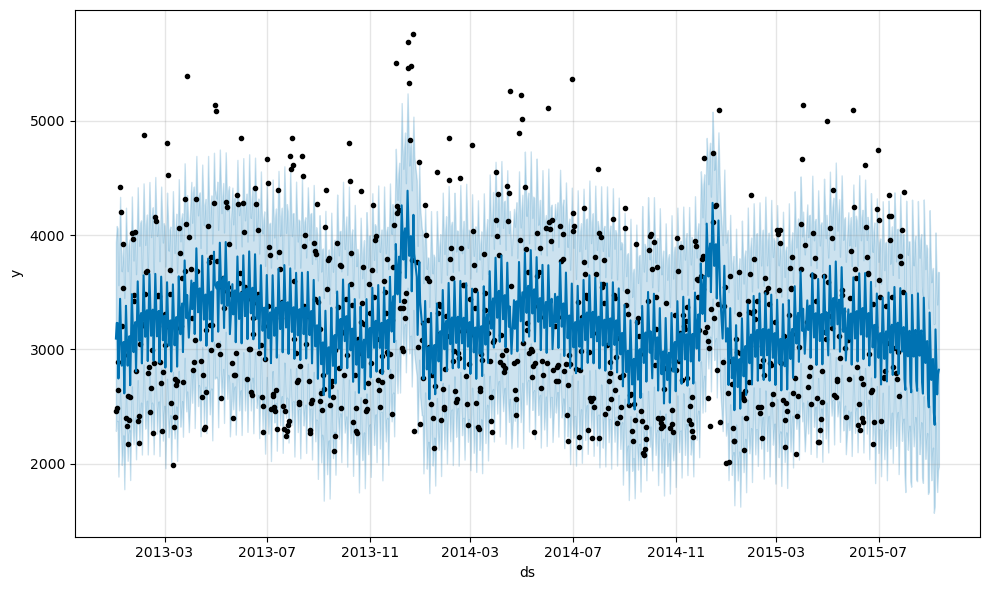

In [42]:
fig1 = prophet_model.plot(prophet_forecast)
fig1.savefig(os.path.join(IMG_PATH, 'prophet_store_{}_forecasted_data'.format(store_id)))

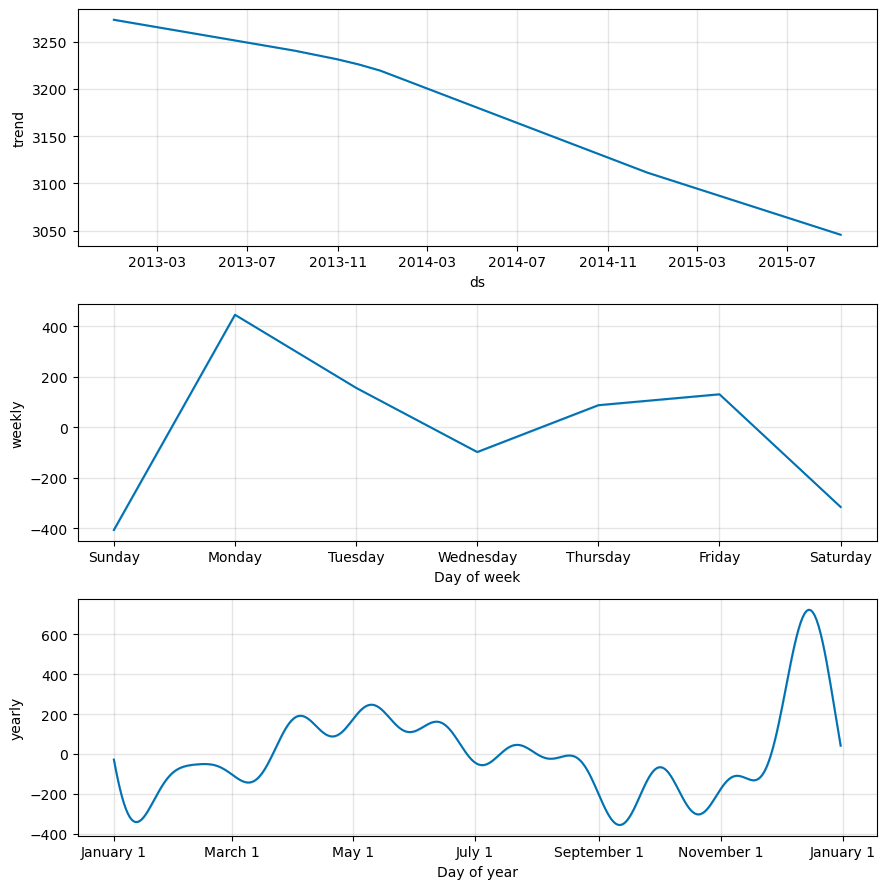

In [43]:
fig2 = prophet_model.plot_components(prophet_forecast)
fig2.savefig(os.path.join(IMG_PATH, 'prophet_store_{}_forecast_components'.format(store_id)))

#### Performance und Erweiterung des Prophet Forecasts
Im nächsten Schritt wird die Performance des Forecast-Modells bewertet und ausgegeben. Hierzu werden die tatsächlichen Werte aus dem DataFrame df_prophet und die vorhergesagten Werte aus dem DataFrame prophet_forecast extrahiert. Dabei wird beachtet, dass die letzten 6*7 (42) Vorhersagewerte entfernt werden, da diese vorhergesagten Werte nicht mit den Actuals verglichen werden können. Anschließend wird der Durchschnittswert der tatsächlichen Werte sowie folgende Performance-Indikatoren berechnet.:
- Mean Absolute Error (MAE): Der MAE misst die durchschnittliche Abweichung zwischen den tatsächlichen und den vorhergesagten Werten, ohne Berücksichtigung der Richtung der Abweichung.
- Mean Squared Error (MSE): Der MSE misst die durchschnittliche quadratische Abweichung zwischen den tatsächlichen und den vorhergesagten Werten.
- Root Mean Squared Error (RMSE): Der RMSE ist die Quadratwurzel des MSE und gibt die durchschnittliche Abweichung zwischen den tatsächlichen und den vorhergesagten Werten in den Originaldateneinheiten wieder.
- Mean Absolute Percentage Error (MAPE): Der MAPE gibt an, wie viel Prozent die durchschnittliche absolute Abweichung der Vorhersagen von den tatsächlichen Werten beträgt.

Im Anschluss wird die Vorhersage um die Feiertage erweitert, um zu prüfen, ob dies zu einer Verbesserung führt. Die Feiertage werden berücksichtigt, um potenzielle Auswirkungen auf das Verkaufsvolumen besser zu erfassen.
Hierfür werden die Daten für die staatlichen Feiertage und die Schulferien aus dem Trainingsdatensatz genommen. Die staatlichen Feiertage sind dort als 'a', 'b' und 'c' gekennzeichnet, während die Schulferien als 1 gekennzeichnet sind. Es werden separate DataFrames für die staatlichen Feiertage und die Schulferien erstellt und anschließend zu einem DataFrame namens "holidays" zusammengeführt. Dieses Dataframe wird dann für die Vorhersage eines neuen Modells verwendet und die gleichen Performance-Indikatoren berechnet.

Die Ergebnisse zeigen, dass die Einbeziehung der Feiertage zu einer leichten Verbesserung der Vorhersageleistung führt. Verglichen mit der Vorhersage ohne Feiertage, zeigt das Modell mit Feiertagen einen etwas geringeren MAE (526.68 gegenüber 528.56) bzw. MAPE (16.85% gegenüber 16.91%). Insgesamt lässt sich sagen, dass die Berücksichtigung von Feiertagen zu einer geringfügigen Verbesserung der Vorhersagegenauigkeit führt, dieser Unterschied ist jedoch nicht signifikant. Es ist möglich, dass die spezifischen Feiertage im betrachteten Zeitraum keine wesentlichen Auswirkungen auf die Verkaufsvorhersage hatten. Für eine detailliertere Analyse könnten möglicherweise spezifischere Informationen zu den Feiertagen oder zusätzliche Merkmale berücksichtigt werden.

In [44]:
def print_prophet_performance(df_actual, df_forecast):
    actual_values = df_actual['y'].values
    predicted_values = df_forecast['yhat'].values[:-6*7]
    print("Mean of actual values:", np.mean(actual_values))
    print("Mean Absolute Error (MAE):", mean_absolute_error(actual_values, predicted_values))
    print("Mean Squared Error (MSE):", mean_squared_error(actual_values, predicted_values))
    print("Root Mean Squared Error (RMSE):", mean_squared_error(actual_values, predicted_values, squared=False))
    print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(actual_values, predicted_values) * 100)

print_prophet_performance(df_prophet, prophet_forecast)

Mean of actual values: 3241.5242346938776
Mean Absolute Error (MAE): 528.5611033891629
Mean Squared Error (MSE): 420419.19221164414
Root Mean Squared Error (RMSE): 648.3974029957585
Mean Absolute Percentage Error (MAPE): 16.909545225782125


In [45]:
state_dates = df_train_store[(df_train_store.StateHoliday == 'a') | (
    df_train_store.StateHoliday == 'b') & (df_train_store.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df_train_store[df_train_store.SchoolHoliday ==
                              1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))
holidays.head()

,holiday,ds
0,state_holiday,2014-10-03
1,state_holiday,2014-05-29
2,state_holiday,2014-06-09
3,state_holiday,2015-05-14
4,state_holiday,2015-05-25


18:47:10 - cmdstanpy - INFO - Chain [1] start processing
18:47:10 - cmdstanpy - INFO - Chain [1] done processing


Mean of actual values: 3241.5242346938776
Mean Absolute Error (MAE): 526.6785583460814
Mean Squared Error (MSE): 414347.9738806956
Root Mean Squared Error (RMSE): 643.6986669868872
Mean Absolute Percentage Error (MAPE): 16.852151780110194


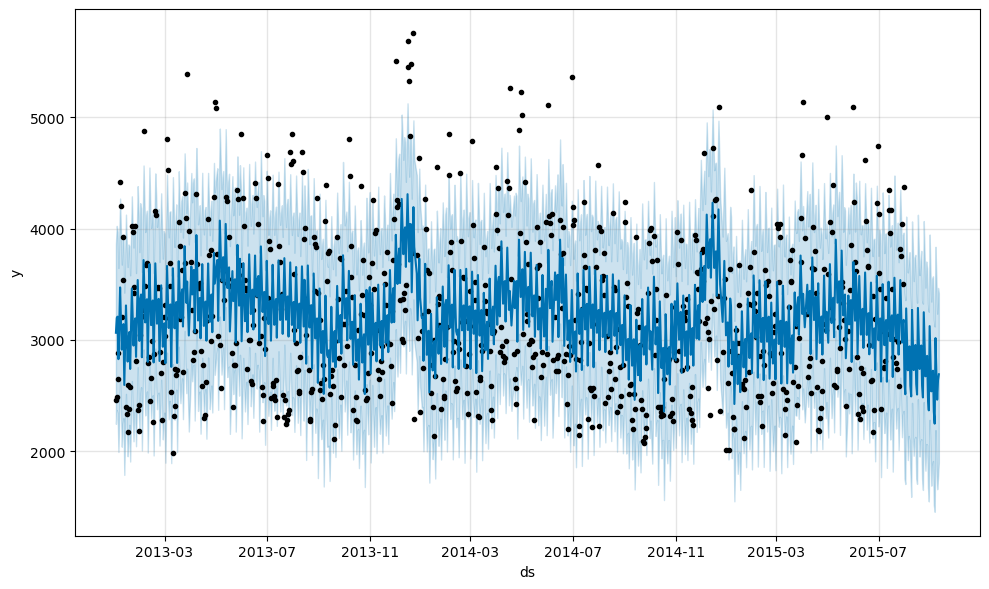

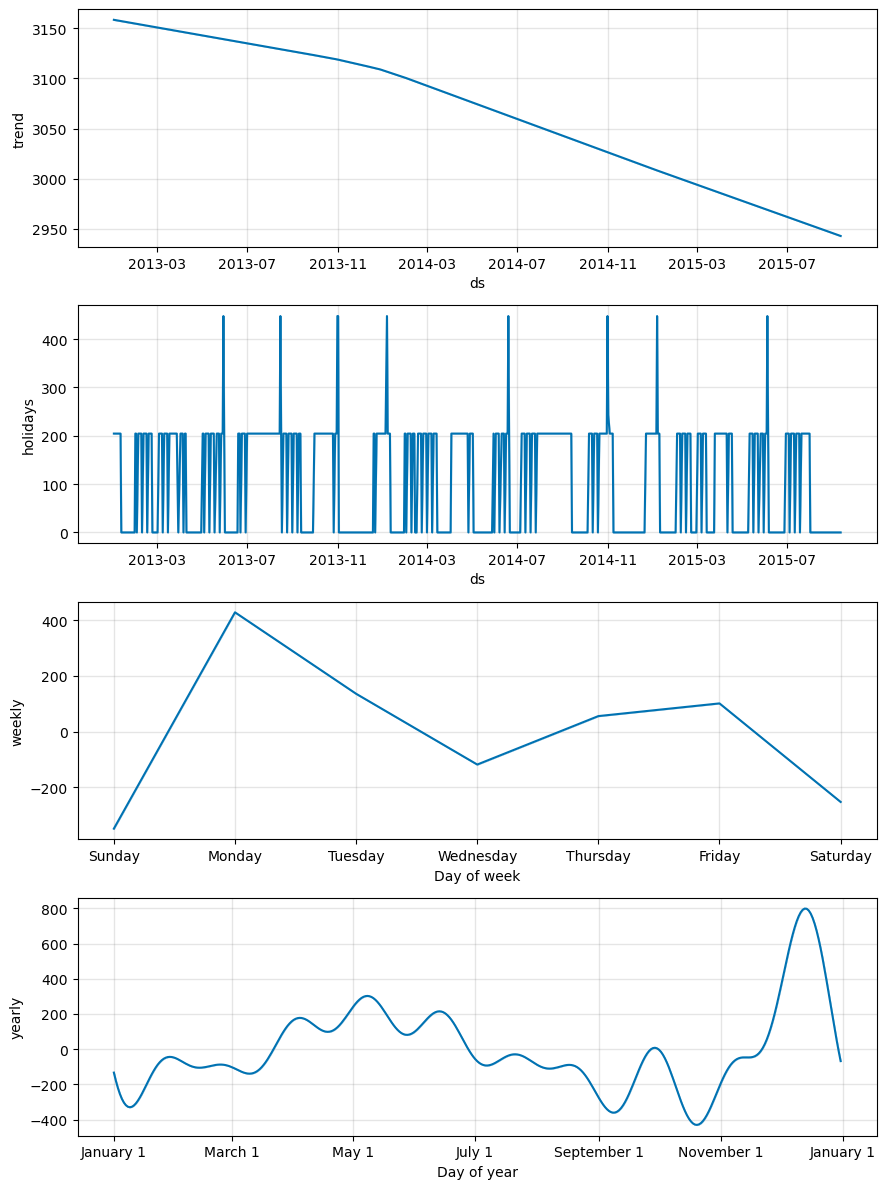

In [46]:
state_dates = df_train_store[(df_train_store.StateHoliday == 'a') | (df_train_store.StateHoliday == 'b') & (df_train_store.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df_train_store[df_train_store.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday', 'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday', 'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))

prophet_model_with_holidays = Prophet(holidays=holidays)
prophet_model_with_holidays.fit(df_prophet)

future = prophet_model_with_holidays.make_future_dataframe(periods=6*7, freq='D')

prophet_forecast_with_holidays = prophet_model_with_holidays.predict(future)

fig1 = prophet_model_with_holidays.plot(prophet_forecast_with_holidays)
fig1.savefig(os.path.join(IMG_PATH, 'prophet_store_{}_forecasted_data_with_holidays'.format(store_id)))
fig2 = prophet_model_with_holidays.plot_components(prophet_forecast_with_holidays)
fig2.savefig(os.path.join(IMG_PATH, 'prophet_store_{}_forecast_components'.format(store_id)))

print_prophet_performance(df_prophet, prophet_forecast_with_holidays)

## 4.2. Zeitreihenanalyse und Forecast mit XGBoost
In diesem Abschnitt wird das XGBoost-Modell verwendet, um den Umsatz für das gleiche Geschäft wie im vorherigen Prophet-Abschnitt vorherzusagen. Zunächst werden die Daten in Trainings- und Test-Daten aufgeteilt, wobei 80% der Daten für das Training und 20% für den Test verwendet werden. Anschließend werden die Features skaliert, um sicherzustellen, dass sie auf eine sinnvolle Skala gebracht werden. 
Beim Training des XGBoost-Modells können ebenfalls verschiedene Parameter mitgegeben werden. Beispiele für diese Parameter sind folgende:
- `objective`: Dieser Parameter definiert das Optimierungsziel des XGBoost-Modells. Es legt fest, welche Verlustfunktion während des Trainings minimiert werden soll. Zum Beispiel wird bei einem Regressionsproblem häufig der Wert "reg:squarederror" verwendet, während bei einem Klassifikationsproblem "binary:logistic" oder "multi:softmax" zum Einsatz kommen können.
- `max_depth`: Dieser Parameter bestimmt die maximale Tiefe der Entscheidungsbäume im XGBoost-Modell. Eine tiefere Baumstruktur ermöglicht es dem Modell, komplexere Muster in den Daten zu erfassen, kann jedoch auch zu Overfitting führen. Eine höhere max_depth kann zu einer besseren Anpassung der Trainingsdaten führen, aber es besteht die Gefahr, dass das Modell die allgemeinen Muster der Daten nicht mehr gut verallgemeinert. Es ist wichtig, die max_depth sorgfältig einzustellen, um Overfitting zu vermeiden.
- `learning_rate`: Dieser Parameter beeinflusst die Schrittweite, mit der das Modell während des Trainings angepasst wird. Eine niedrigere Lernrate ermöglicht präzisere Anpassungen, während eine höhere Lernrate dazu führen kann, dass das Modell schneller konvergiert. Die Wahl einer geeigneten Lernrate ist wichtig, um eine gute Balance zwischen Konvergenzgeschwindigkeit und Modellgenauigkeit zu erreichen.

Die im Code verwendeten Parameter für das XGBoost-Modell wurden von ChatGPT generiert. Im Rahmen dieser Studienarbeit werden die Parameter nicht weiter optimiert.

Abschließend werden für das XGBoost-Modell wie bereits für die Prophet-Modelle die Performance-Indikatoren MAE, MSE, RMSE und MAPE berechnet und ausgegeben, um die Leistung des Modells zu bewerten. 

### 4.3.1. XGBoost Forecast-Beispiel anhand von einem Store

In [47]:
df_xgboost = df_train_store[df_train_store.Store == store_id].loc[:, ['Year', 'Month', 'Day', 'DayOfWeek', 'Sales']]

# Teilen der Daten in Trainings- und Testsets
train_size = int(0.8 * len(df_xgboost))
train_data = df_xgboost[:train_size]
test_data = df_xgboost[train_size:]

# Trennen der Features und Zielvariablen
X_train = train_data.drop('Sales', axis=1)
y_train = train_data['Sales']
X_test = test_data.drop('Sales', axis=1)
y_test = test_data['Sales']

# Skalieren der Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Erstellen der DMatrix für XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Definieren der XGBoost-Parameter - Quelle: ChatGPT
params = {
    'objective': 'reg:squarederror',
    'max_depth': 3,
    'learning_rate': 0.1
}

# Trainieren des XGBoost-Modells
model = xgb.train(params, dtrain)

# Vorhersagen auf dem Testset machen
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

# Berechnung und Ausgabe der Performance-Indikatoren
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Absolute Error (MAE): 1235.8133296116143
Mean Squared Error (MSE): 2106535.162626203
Root Mean Squared Error (RMSE): 1451.3907684101491
Mean Absolute Percentage Error (MAPE): 34.476690192914056


## 4.4. Vergleich der Forecasts
Um die Leistung der verschiedenen Modelle zu vergleichen, wurden verschiedene Performance-Indikatoren berechnet, die eine Bewertung der Vorhersagegenauigkeit ermöglichen. Die Ergebnisse zeigen interessante Unterschiede zwischen den Modellen.
Das XGBoost-Modell erzielte einen durchschnittlichen absoluten Fehler (MAE) von 1235.813 und eine mittlere absolute prozentuale Abweichung (MAPE) von 34.48%, während das Prophet-Modell einen MAE von 528.561 sowie einen MAPE von 16,91% aufwies. Diese Zahlen zeigen, dass das Prophet-Modell im Durchschnitt eine geringere Abweichung zwischen den vorhergesagten und den tatsächlichen Werten aufweist, was auf eine bessere Vorhersagegenauigkeit hinweist. Das Prophet-Modell, welches als zusätzliche Eingabe die Feiertage hat, besitzt nur eine geringfügig bessere Performance im Vergleich zum Prophet-Modell ohne Feiertage. 

Es ist wichtig zu beachten, dass die Parameter der Modelle im Rahmen der Studienarbeit nicht optimiert wurden. Daher dienen sie lediglich als grober Vergleich. Die Unterschiede in den Performance-Indikatoren lassen jedoch darauf schließen, dass das Prophet-Modell im Hinblick auf die Vorhersagegenauigkeit und -präzision gegenüber dem XGBoost-Modell Vorteile aufweisen könnte. Weitere Analysen und Experimente sind empfehlenswert, um die besten Vorhersageergebnisse zu erzielen. Eine umfassendere Evaluierung und Optimierung der Modelle könnte zu weiteren Erkenntnissen und möglicherweise zu einer klaren Empfehlung für das geeignetere Modell führen.

In [48]:
print("Performance of XG-Boost")
print("Mean of actual values:", np.mean(df_prophet['y'].values))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

print("\nPerformance of Prophet")
print_prophet_performance(df_prophet, prophet_forecast)

print("\nPerformance of Prophet with Holidays")
print_prophet_performance(df_prophet, prophet_forecast_with_holidays)

Performance of XG-Boost
Mean of actual values: 3241.5242346938776
Mean Absolute Error (MAE): 1235.8133296116143
Mean Squared Error (MSE): 2106535.162626203
Root Mean Squared Error (RMSE): 1451.3907684101491
Mean Absolute Percentage Error (MAPE): 34.476690192914056

Performance of Prophet
Mean of actual values: 3241.5242346938776
Mean Absolute Error (MAE): 528.5611033891629
Mean Squared Error (MSE): 420419.19221164414
Root Mean Squared Error (RMSE): 648.3974029957585
Mean Absolute Percentage Error (MAPE): 16.909545225782125

Performance of Prophet with Holidays
Mean of actual values: 3241.5242346938776
Mean Absolute Error (MAE): 526.6785583460814
Mean Squared Error (MSE): 414347.9738806956
Root Mean Squared Error (RMSE): 643.6986669868872
Mean Absolute Percentage Error (MAPE): 16.852151780110194


# 5. Fazit
Im Rahmen der Studienarbeit zu dem Thema Data Mining wurde zunächst eine umfassende explorative Datenanalyse der vorliegenden Daten durchgeführt. Anschließend wurden anhand der Modelle seasonal_decompose, Prophet und XGBoost beispielhaft Zeitreihenanalysen durchgeführt um Muster und Trends in den Daten identifiziert und Vorhersagen durchgeführt. Sowohl für die EDA als auch für die Zeitreihenanalyse wurden verschiedene Visualisierungen genutzt, um diese Ergebnisse zu veranschaulichen und ein besseres Verständnis der Daten zu ermöglichen.

Es ist jedoch zu beachten, dass im Rahmen der Studienarbeiten die Parameter der Modelle nicht optimiert wurden und dementsprechend nicht so genau sind, wie sie sein könnten. An dieser Stelle könnte in zukünftigen Arbeiten angesetzt werden. Zusätzlich könnten weitere Faktoren wie beispielsweise die Promo eine Rolle spielen, die nicht in die Analyse einbezogen wurden. Insgesamt hat diese Studienarbeit gezeigt, dass Data Mining ein leistungsstarkes Werkzeug ist, um wertvolle Informationen aus großen Datenmengen zu extrahieren. Durch eine gründliche Analyse und Interpretation der Daten können wertvolle Erkenntnisse gewonnen und auf Basis dieser Erkenntnisse Entscheidungen getroffen werden.